# [VQ-VAE](https://arxiv.org/abs/1711.00937) for audio in PyTorch

This notebook is based on 
https://github.com/zalandoresearch/pytorch-vq-vae

## Introduction

Variational Auto Encoders (VAEs) can be thought of as what all but the last layer of a neural network is doing, namely feature extraction or seperating out the data. Thus given some data we can think of using a neural network for representation generation. 

Recall that the goal of a generative model is to estimate the probability distribution of high dimensional data such as images, videos, audio or even text by learning the underlying structure in the data as well as the dependencies between the different elements of the data. This is very useful since we can then use this representation to generate new data with similar properties. This way we can also learn useful features from the data in an unsupervised fashion.

The VQ-VAE uses a discrete latent representation mostly because many important real-world objects are discrete. For example in images we might have categories like "Cat", "Car", etc. and it might not make sense to interpolate between these categories. Discrete representations are also easier to model since each category has a single value whereas if we had a continous latent space then we will need to normalize this density function and learn the dependencies between the different variables which could be very complex.

### Code

I have followed the code from the TensorFlow implementation by the author which you can find here [vqvae.py](https://github.com/deepmind/sonnet/blob/master/sonnet/python/modules/nets/vqvae.py) and [vqvae_example.ipynb](https://github.com/deepmind/sonnet/blob/master/sonnet/examples/vqvae_example.ipynb). 

Another PyTorch implementation is found at [pytorch-vqvae](https://github.com/ritheshkumar95/pytorch-vqvae).


## Basic Idea

We start by defining a latent embedding space of dimension `[K, D]` where `K` are the number of embeddings and `D` is the dimensionality of each latent embeddng vector $e_i$.

The model will take in batches of waveforms, of size 16126 for our example, and pass it through a ConvNet encoder producing some output, where we make sure the channels are the same as the dimensionality of the latent embedding vectors. To calculate the discrete latent variable we find the nearest embedding vector and output it's index. 

The input to the decoder is the embedding vector corresponding to the index which is passed through the decoder to produce the reconstructed audio. 

Since the nearest neighbour lookup has no real gradient in the backward pass we simply pass the gradients from the decoder to the encoder  unaltered. The intuition is that since the output representation of the encoder and the input to the decoder share the same `D` channel dimensional space, the gradients contain useful information for how the encoder has to change its output to lower the reconstruction loss.

## Loss

The total loss is composed of three components:

1. reconstruction loss which optimizes the decoder and encoder
1. due to the fact that gradients bypass the embedding, we use a dictionary learning algorithm  which uses an $l_2$  error to move the embedding vectors $e_i$ towards the encoder output
1. also since the volume of the embedding space is dimensionless, it can grow arbirtarily if the embeddings $e_i$ do not train as fast as  the encoder parameters, and thus we add a commitment loss to make sure that the encoder commits to an embedding

In [1]:
import os
import subprocess

import math

import matplotlib.pyplot as plt
import numpy as np
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import random
import fastdtw
from wavenet_vocoder.wavenet import WaveNet
from wavenet_vocoder.wavenet import receptive_field_size
#from vq import VectorQuantizerEMA

In [2]:
import easydict
args = easydict.EasyDict({
    "batch": 1,
    "epochs": 50,
    "training_data": './small_data/vctk_train.txt',
    "test_data": './small_data/vctk_test.txt',
#    "training_data": './vctk_train.txt',
#    "test_data": './vctk_test.txt',
#    "out": "result",
#    "resume": False,
    "load": 0,
    "load_mid" : 0,
    "seed": 1 })

In [3]:
device = torch.device("cuda")
#torch.cuda.set_device(0)
device

torch.manual_seed(args.seed)
np.random.seed(args.seed)
random.seed(args.seed)

In [4]:
with open(args.training_data, 'r') as f:
    data = f.read()
file = data.splitlines()
speaker_dic = {}
number_of_speakers = 0
for i in range (0, len(file)):
    if (file[i].split('/')[0] in speaker_dic):
        continue
    else :
        speaker_dic[file[i].split('/')[0]] = number_of_speakers
        number_of_speakers+=1
        

In [5]:
#TO DO: check that weight gets updated
class VectorQuantizerEMA(nn.Module):
    """We will also implement a slightly modified version  which will use exponential moving averages
    to update the embedding vectors instead of an auxillary loss.
    This has the advantage that the embedding updates are independent of the choice of optimizer 
    for the encoder, decoder and other parts of the architecture.
    For most experiments the EMA version trains faster than the non-EMA version."""
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        #self._embedding.weight.data.normal_()
        self._embedding.weight.data.uniform_(-1./512, 1./512)
#        self._embedding.weight.data = torch.Tensor([0])
        #self._embedding.weight.data = torch.Tensor(np.zeros(()))
        self._commitment_cost = commitment_cost
        
        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()
        
        self._decay = decay
        self._epsilon = epsilon
    '''
    def forward(self, inputs):
        # convert inputs from BCL -> BLC
        inputs = inputs.permute(0, 2, 1).contiguous()
        input_shape = inputs.shape
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)     #[BL, C]
        if (self._embedding.weight.data == 0).all():
            self._embedding.weight.data = flat_input[-self._num_embeddings:].detach()
        # Calculate distances

        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t())) #[BL, num_embeddings]
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1) #[BL, 1]
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings).to(device)# [BL, num_embeddings]
        encodings.scatter_(1, encoding_indices, 1)
        #print(encodings.shape) [250, 512]
        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)
            #print(self._ema_cluster_size.shape) [512]
            n = torch.sum(self._ema_cluster_size)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)
            
            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)
            
            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))
        
        # Quantize and unflatten
        #encodings.shape = [BL, num_embeddings] , weight.shape=[num_embeddings, C]
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

        
        # Loss
        e_latent_loss = torch.mean((quantized.detach() - inputs)**2)
        q_latent_loss = torch.mean((quantized - inputs.detach())**2)
#        print(q_latent_loss.item(), 0.25 * e_latent_loss.item())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss
        
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        # convert quantized from BLC -> BCL
        return loss, quantized.permute(0, 2, 1).contiguous(), perplexity
    '''
    
    def forward(self, inputs):
        # convert inputs from BCL -> BLC
        inputs = inputs.permute(0, 2, 1).contiguous()
        input_shape = inputs.shape
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)     #[BL, C]
        # Calculate distances
        
        distances = torch.norm(flat_input.unsqueeze(1) - self._embedding.weight, dim=2, p=2)
 #       distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
 #                   + torch.sum(self._embedding.weight**2, dim=1)
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1) #[BL, 1]
        
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings).to(device)# [BL, num_embeddings]
        encodings.scatter_(1, encoding_indices, 1)
        #print(encodings.shape) [250, 512]

#         # Use EMA to update the embedding vectors
#         if self.training:
#             self._ema_cluster_size = self._ema_cluster_size * self._decay + \
#                                      (1 - self._decay) * torch.sum(encodings, 0)
#             #print(self._ema_cluster_size.shape) [512]
#             n = torch.sum(self._ema_cluster_size)
#             self._ema_cluster_size = (
#                 (self._ema_cluster_size + self._epsilon)
#                 / (n + self._num_embeddings * self._epsilon) * n)
            
#             dw = torch.matmul(encodings.t(), flat_input)
#             self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)
            
#             self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))

        # Quantize and unflatten
        #encodings.shape = [BL, num_embeddings] , weight.shape=[num_embeddings, C]
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        # Loss
        e_latent_loss = torch.mean((quantized.detach() - inputs)**2)
        q_latent_loss = torch.mean((quantized - inputs.detach())**2)
#        print(q_latent_loss.item(), 0.25 * e_latent_loss.item())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss
        
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        # same as torch.exp( entropy loss )
        
        # convert quantized from BLC -> BCL
        return loss, quantized.permute(0, 2, 1).contiguous(), perplexity
#    '''

In [6]:
# embedding_dim=1
# num_embeddings=2
# ema = VectorQuantizerEMA(embedding_dim=embedding_dim,
#                         num_embeddings=num_embeddings,
#                         commitment_cost=0.5,
#                         decay=0.99,
#                         device=device)
  
# ema.eval()
# print("is training", ema.training)
# inputs_np = np.random.randn(20, embedding_dim).astype(np.float32)
# print("inputs", inputs_np)
# inputs = torch.Tensor(inputs_np.reshape(1,embedding_dim,20))

# loss, vq_output, perplexity = ema(inputs)
# print("loss", loss)
# print("output", vq_output)
# # Output shape is correct
# assert vq_output.shape == inputs.shape
    
# #assert ema._embedding.weight.detach().numpy().shape == [embedding_dim, num_embeddings]
# # Check that each input was assigned to the embedding it is closest to.
# embeddings_np = ema._embedding.weight.detach().numpy().T
# distances = ((inputs_np**2).sum(axis=1, keepdims=True) -
#              2 * np.dot(inputs_np, embeddings_np) +
#              (embeddings_np**2).sum(axis=0, keepdims=True))
# closest_index = np.argmax(-distances, axis=1)

# print(closest_index)

## Encoder & Decoder Architecture

In [7]:
class Encoder(nn.Module):
    """Audio encoder
    The vq-vae paper says that the encoder has 6 strided convolutions with stride 2 and window-size 4.
    The number of channels and a nonlinearity is not specified in the paper. 
    I tried using ReLU, it didn't work.
    Now I try using tanh, hoping that this will keep my encoded values within the neighborhood of 0,
    so they do not drift too far away from encoding vectors.
    """
    def __init__(self, encoding_channels, in_channels=256):
        super(Encoder,self).__init__()
        self._num_layers = 2 * len(encoding_channels)
        self._layers = nn.ModuleList()
        for out_channels in encoding_channels:
            self._layers.append(nn.Conv1d(in_channels=in_channels,
                                    out_channels=out_channels,
                                    stride=2,
                                    kernel_size=4,
                                    padding=0, 
                                        ))
            self._layers.append(nn.Tanh())
            in_channels = out_channels
        
    def forward(self, x):
        for i in range(self._num_layers):
            x = self._layers[i](x)
        return x

In [8]:
class Model(nn.Module):
    def __init__(self,
                 encoding_channels,
                 num_embeddings, 
                 embedding_dim,
                 commitment_cost, 
                 layers,
                 stacks,
                 kernel_size,
                 decay=0):
        super(Model, self).__init__()       
        self._encoder = Encoder(encoding_channels=encoding_channels)
        #I tried adding batch normalization here, because:
        #the distribution of encoded values needs to be similar to the distribution of embedding vectors
        #otherwise we'll see "posterior collapse": all values will be assigned to the same embedding vector,
        #and stay that way (because vectors which do not get assigned anything do not get updated).
        #Batch normalization is a way to fix that. But it didn't work: model
        #reproduced voice correctly, but the words were completely wrong.
        #self._batch_norm = nn.BatchNorm1d(1)
        if decay > 0.0:
#             self._vq_vae = EMVectorQuantizerEMA(num_embeddings, embedding_dim, 
#                                               commitment_cost, decay, 100)
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim, 
                                               commitment_cost, decay)

        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim,
                                           commitment_cost)
        self._decoder = WaveNet(device, out_channels=256, #dimension of ohe mu-quantized signal
                                layers=layers, #like in original WaveNet
                                stacks=stacks,
                                residual_channels=512,
                                gate_channels=512,
                                skip_out_channels=512,
                                kernel_size=kernel_size, 
                                dropout=1 - 0.95,
                                cin_channels=embedding_dim, #local conditioning channels - on encoder output
                                gin_channels=number_of_speakers, #global conditioning channels - on speaker_id
                                n_speakers=number_of_speakers,
                                weight_normalization=False, 
                                upsample_conditional_features=True, 
                                decoding_channels=encoding_channels[::-1],
                                use_speaker_embedding=False
                               )
        self.recon_loss = torch.nn.CrossEntropyLoss()
        self.receptive_field = receptive_field_size(total_layers=layers, num_cycles=stacks, kernel_size=kernel_size)
#        self.mean = None
#        self.std = None
    def forward(self, x):
        audio, target, speaker_id = x
        assert len(audio.shape) == 3 # B x C x L 
        assert audio.shape[1] == 256
        z = self._encoder(audio)
        #normalize output - subtract mean, divide by standard deviation
        #without this, perplexity goes to 1 almost instantly
#         if self.mean is None:
#             self.mean = z.mean().detach()
#         if self.std is None:
#              self.std = z.std().detach()
#        z = z - self.mean
#        z = z / self.std
        vq_loss, quantized, perplexity = self._vq_vae(z)
#        assert z.shape == quantized.shape
#        print("audio.shape", audio.shape)
#        print("quantized.shape", quantized.shape)
        x_recon = self._decoder(audio, quantized, speaker_id, softmax=False)
        x_recon = x_recon[:, :, self.receptive_field:-1]
        recon_loss_value = self.recon_loss(x_recon, target[:, 1:])
        loss = recon_loss_value + vq_loss
        
        return loss, recon_loss_value, x_recon, perplexity

# Train

In [9]:
num_training_updates = 39818
#vector quantizer parameters:
embedding_dim = 64 #dimension of each vector
encoding_channels = [512,512,512,512,512,embedding_dim]
num_embeddings = 512 #number of vectors
commitment_cost = 0.25

#wavenet parameters:
kernel_size=2
total_layers=30
num_cycles=3


decay = 0.99
#decay = 0

learning_rate = 1e-3
batch_size=1

In [10]:
receptive_field = receptive_field_size(total_layers=total_layers, num_cycles=num_cycles, kernel_size=kernel_size)
print(receptive_field)

3070


## Load data

In [11]:
model = Model(num_embeddings=num_embeddings,
              encoding_channels=encoding_channels,
              embedding_dim=embedding_dim, 
              commitment_cost=commitment_cost, 
              layers=total_layers,
              stacks=num_cycles,
              kernel_size=kernel_size,
              decay=decay).to(device)

In [12]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

In [13]:
    '''
# data = VCTK("/gpfs/gpfs0/a.phan/Vika_voice_conversion/VCTK", receptive_field=receptive_field)
data = VCTK("./VCTK", receptive_field=receptive_field)
print(len(data))
indices = np.arange(len(data))
test_size = len(data) // 10

train_indices = indices[:-test_size]
test_indices = indices[-test_size:]

training_loader = DataLoader(data, 
                           batch_size=1,
                           shuffle=False, 
                           num_workers=1,
                           sampler=SubsetSequentialSampler(train_indices))

validation_loader = DataLoader(data, 
                           batch_size=1,
                           shuffle=False, 
                           num_workers=1,
                           sampler=SubsetSequentialSampler(test_indices))
    '''

'\n# data = VCTK("/gpfs/gpfs0/a.phan/Vika_voice_conversion/VCTK", receptive_field=receptive_field)\ndata = VCTK("./VCTK", receptive_field=receptive_field)\nprint(len(data))\nindices = np.arange(len(data))\ntest_size = len(data) // 10\n\ntrain_indices = indices[:-test_size]\ntest_indices = indices[-test_size:]\n\ntraining_loader = DataLoader(data, \n                       batch_size=1,\n                       shuffle=False, \n                       num_workers=1,\n                       sampler=SubsetSequentialSampler(train_indices))\n\nvalidation_loader = DataLoader(data, \n                       batch_size=1,\n                       shuffle=False, \n                       num_workers=1,\n                       sampler=SubsetSequentialSampler(test_indices))\n'

In [14]:
import librosa

In [16]:
class TrainingSet(Dataset):
    # VCTK-Corpus Training data set

    def __init__(self, num_speakers,
                 receptive_field,
                 segment_length=16126,
                 chunk_size=1000,
                 classes=256):
        
        self.x_list = self.read_files(args.training_data)
        self.classes = 256
        self.segment_length = segment_length
        self.chunk_size = chunk_size
        self.classes = classes
        self.receptive_field = receptive_field
        self.cached_pt = 0
        self.num_speakers = num_speakers

    def read_files(self, filename):
        print("training data from " + args.training_data)
        with open(filename) as file:
            files = file.readlines()
        return [f.strip() for f in files]

    def __getitem__(self, index):
        try:
            audio, sr = librosa.load('./VCTK/wav48/'+self.x_list[index])
        except Exception as e:
            print(e, audiofile)
        if sr != 22050:
            raise ValueError("{} SR of {} not equal to 22050".format(sr, audiofile))
            
        audio = librosa.util.normalize(audio) #divide max(abs(audio))
        audio = self.quantize_data(audio, self.classes)
            
        while audio.shape[0] < self.segment_length:
            index += 1
            audio, speaker_id = librosa.load('./VCTK/wav48/'+self.x_list[index])
            
        max_audio_start = audio.shape[0] - self.segment_length
        audio_start = random.randint(0, max_audio_start)
        audio = audio[audio_start:audio_start+self.segment_length]
        
                #divide into input and target
        audio = torch.from_numpy(audio)
        ohe_audio = torch.FloatTensor(self.classes, self.segment_length).zero_()
        ohe_audio.scatter_(0, audio.unsqueeze(0), 1.)
        target = audio[self.receptive_field:]
            
        speaker_index = speaker_dic[self.x_list[index].split('/')[0]]
        speaker_id = torch.from_numpy(np.array(speaker_index)).unsqueeze(0).unsqueeze(0)
        ohe_speaker = torch.FloatTensor(self.num_speakers, 1).zero_()
        ohe_speaker.scatter_(0, speaker_id, 1.)
        
        return ohe_audio, target, ohe_speaker
    
    def __len__(self):

        return len(self.x_list)
    
    def quantize_data(self, data, classes):
        mu_x = self.mu_law_encode(data, classes)
        bins = np.linspace(-1, 1, classes)
        quantized = np.digitize(mu_x, bins) - 1
        return quantized

    def mu_law_encode(self, data, mu):
        mu_x = np.sign(data) * np.log(1 + mu * np.abs(data)) / np.log(mu + 1)
        return mu_x

In [17]:
class TestSet(Dataset):
    # VCTK-Corpus Test data set


    def __init__(self, num_speakers,
                 receptive_field,
                 segment_length=16126,
                 chunk_size=1000,
                 classes=256):
        
        
        self.x_list = self.read_files(args.test_data)
        self.classes = 256
        self.segment_length = segment_length
        self.chunk_size = chunk_size
        self.classes = classes
        self.receptive_field = receptive_field
        self.cached_pt = 0
        self.num_speakers = num_speakers


    def read_files(self, filename):
        print("training data from " + args.test_data)
        with open(filename) as file:
            files = file.readlines()
        return [f.strip() for f in files]

    def __getitem__(self, index):
        try:
            audio, sr = librosa.load('./VCTK/wav48/'+self.x_list[index])
        except Exception as e:
            print(e, audiofile)
        if sr != 22050:
            raise ValueError("{} SR of {} not equal to 22050".format(sr, audiofile))
        
        audio = librosa.util.normalize(audio) #divide max(abs(audio))
        audio = self.quantize_data(audio, self.classes)
            
        while audio.shape[0] < self.segment_length:
            index += 1
            audio, speaker_id = librosa.load('./VCTK/wav48/'+self.x_list[index])
            
        max_audio_start = audio.shape[0] - self.segment_length
        audio_start = random.randint(0, max_audio_start)
        audio = audio[audio_start:audio_start+self.segment_length]
        
                #divide into input and target
        audio = torch.from_numpy(audio)
        ohe_audio = torch.FloatTensor(self.classes, self.segment_length).zero_()
        ohe_audio.scatter_(0, audio.unsqueeze(0), 1.)
        target = audio[self.receptive_field:]
            
        speaker_index = speaker_dic[self.x_list[index].split('/')[0]]
        speaker_id = torch.from_numpy(np.array(speaker_index)).unsqueeze(0).unsqueeze(0)
        ohe_speaker = torch.FloatTensor(self.num_speakers, 1).zero_()
        ohe_speaker.scatter_(0, speaker_id, 1.)
        
        return ohe_audio, target, ohe_speaker

    def __len__(self):
        return len(self.x_list)

    def quantize_data(self, data, classes):
        mu_x = self.mu_law_encode(data, classes)
        bins = np.linspace(-1, 1, classes)
        quantized = np.digitize(mu_x, bins) - 1
        return quantized

    def mu_law_encode(self, data, mu):
        mu_x = np.sign(data) * np.log(1 + mu * np.abs(data)) / np.log(mu + 1)
        return mu_x

In [18]:
trainset = TrainingSet(number_of_speakers, receptive_field=receptive_field)
testset = TestSet(number_of_speakers, receptive_field=receptive_field)


training_loader = DataLoader(dataset = trainset,
                           batch_size=batch_size,
                           shuffle=True, 
                           num_workers=1)


validation_loader = DataLoader(dataset = testset,
                           batch_size=batch_size,
                           shuffle=True, 
                           num_workers=1)

training data from ./small_data/vctk_train.txt
training data from ./small_data/vctk_test.txt


In [19]:
train_res_recon_error = []
train_res_perplexity = []

In [20]:
def train():
    model.train()
    global train_res_recon_error
    global train_res_perplexity
    train_total_loss = []
    train_recon_error = []
    train_perplexity = []
    # with open("errors", "rb") as file:
    #     train_res_recon_error, train_res_perplexity = pickle.load(file)
# num_epochs = 1
# for epoch in range(num_epochs):
    iterator = iter(training_loader)
#     datas0 = []
#     datas1 = []
#     datas2 = []
    for i, data_train in enumerate(iterator):
        data_train = [data_train[0].to(device),
                     data_train[1].to(device),
                     data_train[2].to(device)
                     ]

#         datas0.append(data_train[0])
#         datas1.append(data_train[1])
#         datas2.append(data_train[2])
#         if (i+1) % batch_size == 0:
#             data = [torch.cat(datas0).to(device),
#                    torch.cat(datas1).to(device),
#                    torch.cat(datas2).to(device)]
        optimizer.zero_grad()
        loss, recon_error, data_recon, perplexity = model(data_train)
        loss.backward()
        optimizer.step()
        train_total_loss.append(loss.item())
        train_recon_error.append(recon_error.item())
        train_perplexity.append(perplexity.item())

        if (i+1) % (10 * batch_size) == 0:
            print('%d iterations' % (i+1))
            print('recon_error: %.3f' % np.mean(train_recon_error[-100:]))
            print('perplexity: %.3f' % np.mean(train_perplexity[-100:]))
            print()
    train_res_recon_error.extend(train_recon_error)
    train_res_perplexity.extend(train_perplexity)
    return np.mean(train_total_loss), np.mean(train_res_recon_error)

In [21]:
def validation():
    model.eval()
    with torch.no_grad():
        test_total_loss = []
        test_res_recon_error = []
        # with open("errors", "rb") as file:
        #     train_res_recon_error, train_res_perplexity = pickle.load(file)
    # num_epochs = 1
    # for epoch in range(num_epochs):
        iterator = iter(validation_loader)
    #     datas0 = []
    #     datas1 = []
    #     datas2 = []
        for i, data_test in enumerate(iterator):
            data_test = [data_test[0].to(device),
                         data_test[1].to(device),
                         data_test[2].to(device)]
            
            loss, recon_error, data_recon, perplexity = model(data_test)

            test_total_loss.append(loss.item())
            test_res_recon_error.append(recon_error.item())

            if (i+1) % (10 * batch_size) == 0:
                print('%d iterations' % (i+1))
                print('recon_error: %.3f' % np.mean(test_res_recon_error[-100:]))
                print()
    return np.mean(test_total_loss), np.mean(test_res_recon_error)

In [22]:
from fastdtw import fastdtw

def conversion(original_wav, speaker):
    model.eval()
    with torch.no_grad():
        generated_file = np.array([])
        wav, sr = librosa.load(original_wav)
        speaker_index = speaker_dic[speaker]
        
        normalized = librosa.util.normalize(wav)
        quantized = quantize_data(normalized, 256)

        for i in range(0, len(wav), 16126):
            sample = quantized[i:i+16126]
            if (len(sample)!= 16126):
                sample = np.append(sample, np.zeros(16126 - len(sample)).astype(int))
                
            sample = torch.from_numpy(sample)
            ohe_audio = torch.FloatTensor(256, 16126).zero_()
            ohe_audio.scatter_(0, sample.unsqueeze(0), 1.)
            
            speaker_id = torch.from_numpy(np.array(speaker_index)).unsqueeze(0).unsqueeze(0)
            ohe_speaker = torch.FloatTensor(number_of_speakers, 1).zero_()
            ohe_speaker.scatter_(0, speaker_id, 1.)

            ohe_audio = ohe_audio.unsqueeze(0).to(device)
            ohe_speaker = ohe_speaker.unsqueeze(0).to(device)
            encoded = model._encoder(ohe_audio)
            _, valid_quantize, _ = model._vq_vae(encoded)
            
            valid_reconstructions = model._decoder.incremental_forward(ohe_audio[:,:,0:1], 
                                                               valid_quantize, 
                                                               ohe_speaker, 
                                                               T=16126)
            recon = valid_reconstructions.squeeze().argmax(dim=0).detach().cpu().numpy()
            mu_encoded = (recon + 1) / 128 - 1
            mu_decoded = mu_law_decode(recon, mu=256)
            generated_file = np.append(generated_file, mu_encoded)
        # librosa.output.write_wav("generated.wav",  generated_file, sr=sr)
        return wav, generated_file, sr

In [23]:
def getMFCC(y, sr, n_mfcc = 24):
    data = librosa.feature.mfcc(y=y, sr = sr, n_fft=4096, n_mfcc=n_mfcc)
    return data

In [24]:
def cal_mcd(C, C_hat):
    if C.ndim==2:
        K = 10 * np.sqrt(2) / np.log(10)
        return K * np.mean(np.sqrt(np.sum((C - C_hat) ** 2, axis = 1)))
    elif C.ndim==1:
        K = 10 * np.sqrt(2) / np.log(10)
        return K * np.mean(np.sqrt(np.sum((C - C_hat) ** 2)))

In [25]:
def calculate_mcd(C, C_hat, sr):
    c, r = C.shape
    cc, rc = C_hat.shape
    a, b = fastdtw(C.T, C_hat.T, dist=cal_mcd)
    b = np.array(b)
    if (r > rc):
        fdtw_C = np.zeros(shape=(r,c))
        fdtw_C_hat = np.zeros(shape=(r,c))
        for j in range(0, r):
            fdtw_C[j] = C.T[b[j][0]]
            fdtw_C_hat[j] = C_hat.T[b[j][1]]
    else:
        fdtw_C = np.zeros(shape=(rc,cc))
        fdtw_C_hat = np.zeros(shape=(rc,cc))
        for j in range(0, rc):
            fdtw_C[j] = C.T[b[j][0]]
            fdtw_C_hat[j] = C_hat.T[b[j][1]]
    mcd = cal_mcd(fdtw_C, fdtw_C_hat)
    return mcd

In [26]:
def logpowerspec2(fftsize, data):
    T, dim = data.shape
    padded_data = np.zeros((fftsize, dim))
    padded_data[:T] += data
    
    complex_spec = np.fft.rfft(padded_data, fftsize, axis = 0)
    R, I = complex_spec.real, complex_spec.imag
    logpowerspec2 = np.log(R*R + I*I)
    
    return logpowerspec2

def extract_ms(mcep):
    ms = logpowerspec2(4096, mcep)
    return ms

def msd_cal(converted_ms, target_ms):
    msd = np.sqrt(np.mean(np.power((converted_ms - target_ms), 2)))
    return msd

def calculate_msd(C, C_hat, sr):
    c, r = C.shape
    cc, rc = C_hat.shape
    a, b = fastdtw(C.T, C_hat.T, dist=msd_cal)
    b = np.array(b)
    if (r > rc):
        fdtw_C = np.zeros(shape=(r,c))
        fdtw_C_hat = np.zeros(shape=(r,c))
        for j in range(0, r):
            fdtw_C[j] = C.T[b[j][0]]
            fdtw_C_hat[j] = C_hat.T[b[j][1]]
    else:
        fdtw_C = np.zeros(shape=(rc,cc))
        fdtw_C_hat = np.zeros(shape=(rc,cc))
        for j in range(0, rc):
            fdtw_C[j] = C.T[b[j][0]]
            fdtw_C_hat[j] = C_hat.T[b[j][1]]
    msd = msd_cal(fdtw_C, fdtw_C_hat)
    return msd

In [27]:
def calc_mcd_msd(conversion_list, data_path = './VCTK'):
    
    mcd = []
    msd = []
    for j in range(0, len(conversion_list)):
        original, conversed, sr = conversion(original_wav = data_path + conversion_list[j][0].item(), speaker = conversion_list[i][1].item())
        compair, _ = librosa.load(data_path + conversion_list[j][2].item())
        conversed[:len(original)]
        C = getMFCC(compair, sr)
        C_hat = getMFCC(conversed, sr)
        mcd.append(calculate_mcd(C, C_hat,sr))
        C = extract_ms(C)
        C_hat = extract_ms(C_hat)
        msd.append(calculate_msd(C, C_hat, sr))

    return  np.mean(mcd).item(), np.var(mcd).item(), np.mean(msd).item(), np.var(msd).item()

In [28]:
def mu_law_encode(data, mu):
    mu_x = np.sign(data) * np.log(1 + mu * np.abs(data)) / np.log(mu + 1)
    return mu_x

def mu_law_decode(mu_x, mu):
    data = np.sign(mu_x) * (1 / mu) * ((1 + mu) ** np.abs(mu_x) - 1)
    return data

def quantize_data(data, classes):
    mu_x = mu_law_encode(data, classes)
    bins = np.linspace(-1, 1, classes)
    quantized = np.digitize(mu_x, bins) - 1
    return quantized

In [29]:
epochs = args.epochs
training_total_loss_per_epochs = []
training_reconstruction_errors_per_epochs = []
validation_total_loss_per_epochs = []
validation_reconstruction_errors_per_epochs = []
training_mcd_per_epochs = []
validation_mcd_per_epochs = []

mcd_per_epochs = []
msd_per_epochs = []

var_mcd_per_epochs = []
var_msd_per_epochs = []

validate_mcd_per_epochs = []
validate_msd_per_epochs = []

validate_var_mcd_per_epochs = []
validate_var_msd_per_epochs = []


conversion_list = np.array([])
conversion_list = np.load('./small_data/m_train_set.npy')

validate_conversion_list = np.array([])
validate_conversion_list = np.load('./small_data/m_test_set.npy')

if (args.load != 0):
    model.load_state_dict(torch.load("model_epoch"+str(args.load)))
    optimizer.load_state_dict(torch.load("optim_epoch"+str(args.load)))
    training_total_loss_per_epochs = np.load('training_total_loss_per_epochs'+str(args.load)+'.npy').tolist()
    training_reconstruction_errors_per_epochs = np.load('training_reconstruction_errors_per_epochs'+str(args.load)+'.npy').tolist()
    validation_total_loss_per_epochs = np.load('validation_total_loss_per_epochs'+str(args.load)+'.npy').tolist()
    validation_reconstruction_errors_per_epochs = np.load('validation_reconstruction_errors_per_epochs'+str(args.load)+'.npy').tolist()
    mcd_per_epochs = np.load('mean_of_mcd_per_epochs.npy', np.array(mcd_per_epochs))
    msd_per_epochs = np.load('mean_of_msd_per_epochs.npy', np.array(msd_per_epochs))
    var_mcd_per_epochs = np.load('var_of_mcd_per_epochs.npy', np.array(var_mcd_per_epochs))
    var_msd_per_epochs = np.load('var_of_msd_per_epochs.npy', np.array(var_msd_per_epochs))
    
    validate_mcd_per_epochs = np.load('validate_mean_of_mcd_per_epochs.npy', np.array(validate_mcd_per_epochs))
    validate_msd_per_epochs = np.load('validate_mean_of_msd_per_epochs.npy', np.array(validate_msd_per_epochs))
    validate_var_mcd_per_epochs = np.load('validate_var_of_mcd_per_epochs.npy', np.array(validate_var_mcd_per_epochs))
    validate_var_msd_per_epochs = np.load('validate_var_of_msd_per_epochs.npy', np.array(validate_var_msd_per_epochs))
    
    
    
if (args.load_mid != 0 and args.load == 0):
    model.load_state_dict(torch.load("model_epoch"+str(args.load)))
    optimizer.load_state_dict(torch.load("optim_epoch"+str(args.load)))


for i in range(1, epochs+1):
    
    print(str(i)+" epochs ==> training")
    total_loss, reconstruction_loss = train()
    training_total_loss_per_epochs.append(total_loss)
    training_reconstruction_errors_per_epochs.append(reconstruction_loss)
    
#     if (i % 5 == 0):
#         mcdm, mcdv, msdm, msdv = calc_mcd_msd(conversion_list ,data_path = './VCTK/wav48/')
#         mcd_per_epoch.append(mcdm)
#         var_mcd_per_epochs.append(mcdv)
#         msd_per_epoch.append(msdm)
#         var_msd_per_epoch.append(msdv)
    
    print(str(i)+" epochs ==> validation")
    total_loss, reconstruction_loss = validation()
    training_total_loss_per_epochs.append(total_loss)
    training_reconstruction_errors_per_epochs.append(reconstruction_loss)
    
#     if (i % 5 == 0):
#         mcdm, mcdv, msdm, msdv = calc_mcd_msd(validate_conversion_list ,data_path='./VCTK/wav48/')
#         validate_mcd_per_epoch.append(mcdm)
#         validate_var_mcd_per_epochs.append(mcdv)
#         validate_msd_per_epoch.append(msdm)
#         validate_var_msd_per_epoch.append(msdv)

    
    if (i % 5 == 0):
        torch.save(model.state_dict(), "model_epoch"+str(i+args.load))
        torch.save(optimizer.state_dict(), "optim_epoch"+str(i+args.load))

if (args.load_mid == 0):
    np.save('training_total_loss_per_epochs'+str(args.epochs + args.load), np.array(training_total_loss_per_epochs))
    np.save('training_reconstruction_errors_per_epochs'+str(args.epochs + args.load), np.array(training_reconstruction_errors_per_epochs))
    np.save('validation_total_loss_per_epochs'+str(args.epochs + args.load), np.array(validation_total_loss_per_epochs))
    np.save('validation_reconstruction_errors_per_epochs'+str(args.epochs + args.load), np.array(validation_reconstruction_errors_per_epochs))

    np.save('mean_of_mcd_per_epochs', np.array(mcd_per_epochs))
    np.save('mean_of_msd_per_epochs', np.array(msd_per_epochs))
    np.save('var_of_mcd_per_epochs', np.array(var_mcd_per_epochs))
    np.save('var_of_msd_per_epochs', np.array(var_msd_per_epochs))
    
    np.save('validate_mean_of_mcd_per_epochs', np.array(validate_mcd_per_epochs))
    np.save('validate_mean_of_msd_per_epochs', np.array(validate_msd_per_epochs))
    np.save('validate_var_of_mcd_per_epochs', np.array(validate_var_mcd_per_epochs))
    np.save('validate_var_of_msd_per_epochs', np.array(validate_var_msd_per_epochs))

1 epochs ==> training
10 iterations
recon_error: 5.555
perplexity: 1.143

20 iterations
recon_error: 5.524
perplexity: 1.604

30 iterations
recon_error: 5.489
perplexity: 1.994

40 iterations
recon_error: 5.481
perplexity: 2.264

50 iterations
recon_error: 5.483
perplexity: 2.378

60 iterations
recon_error: 5.463
perplexity: 2.385

70 iterations
recon_error: 5.442
perplexity: 2.340

80 iterations
recon_error: 5.419
perplexity: 2.219

90 iterations
recon_error: 5.347
perplexity: 2.184

100 iterations
recon_error: 5.265
perplexity: 2.125

110 iterations
recon_error: 5.171
perplexity: 2.182

120 iterations
recon_error: 5.054
perplexity: 2.184

130 iterations
recon_error: 4.939
perplexity: 2.090

140 iterations
recon_error: 4.762
perplexity: 1.996

150 iterations
recon_error: 4.608
perplexity: 1.905

160 iterations
recon_error: 4.443
perplexity: 1.901

170 iterations
recon_error: 4.314
perplexity: 1.917

180 iterations
recon_error: 4.153
perplexity: 2.004

190 iterations
recon_error: 4.040

330 iterations
recon_error: 2.288

340 iterations
recon_error: 2.276

350 iterations
recon_error: 2.242

360 iterations
recon_error: 2.262

370 iterations
recon_error: 2.258

380 iterations
recon_error: 2.209

390 iterations
recon_error: 2.210

2 epochs ==> training
10 iterations
recon_error: 2.103
perplexity: 17.714

20 iterations
recon_error: 2.201
perplexity: 15.645

30 iterations
recon_error: 2.193
perplexity: 17.056

40 iterations
recon_error: 2.163
perplexity: 17.546

50 iterations
recon_error: 2.112
perplexity: 17.675

60 iterations
recon_error: 2.178
perplexity: 17.742

70 iterations
recon_error: 2.125
perplexity: 17.560

80 iterations
recon_error: 2.177
perplexity: 18.099

90 iterations
recon_error: 2.192
perplexity: 18.866

100 iterations
recon_error: 2.214
perplexity: 19.391

110 iterations
recon_error: 2.219
perplexity: 19.852

120 iterations
recon_error: 2.214
perplexity: 20.861

130 iterations
recon_error: 2.244
perplexity: 20.871

140 iterations
recon_error: 2.260
perple

230 iterations
recon_error: 2.190

240 iterations
recon_error: 2.155

250 iterations
recon_error: 2.165

260 iterations
recon_error: 2.152

270 iterations
recon_error: 2.147

280 iterations
recon_error: 2.125

290 iterations
recon_error: 2.202

300 iterations
recon_error: 2.197

310 iterations
recon_error: 2.257

320 iterations
recon_error: 2.247

330 iterations
recon_error: 2.237

340 iterations
recon_error: 2.204

350 iterations
recon_error: 2.199

360 iterations
recon_error: 2.205

370 iterations
recon_error: 2.188

380 iterations
recon_error: 2.202

390 iterations
recon_error: 2.099

3 epochs ==> training
10 iterations
recon_error: 2.417
perplexity: 32.564

20 iterations
recon_error: 2.210
perplexity: 32.798

30 iterations
recon_error: 2.199
perplexity: 32.526

40 iterations
recon_error: 2.134
perplexity: 34.148

50 iterations
recon_error: 2.169
perplexity: 32.709

60 iterations
recon_error: 2.165
perplexity: 31.590

70 iterations
recon_error: 2.142
perplexity: 31.899

80 iteration

130 iterations
recon_error: 2.058

140 iterations
recon_error: 2.061

150 iterations
recon_error: 2.113

160 iterations
recon_error: 2.142

170 iterations
recon_error: 2.177

180 iterations
recon_error: 2.220

190 iterations
recon_error: 2.193

200 iterations
recon_error: 2.259

210 iterations
recon_error: 2.228

220 iterations
recon_error: 2.214

230 iterations
recon_error: 2.205

240 iterations
recon_error: 2.180

250 iterations
recon_error: 2.154

260 iterations
recon_error: 2.141

270 iterations
recon_error: 2.123

280 iterations
recon_error: 2.092

290 iterations
recon_error: 2.140

300 iterations
recon_error: 2.118

310 iterations
recon_error: 2.118

320 iterations
recon_error: 2.122

330 iterations
recon_error: 2.095

340 iterations
recon_error: 2.096

350 iterations
recon_error: 2.162

360 iterations
recon_error: 2.144

370 iterations
recon_error: 2.134

380 iterations
recon_error: 2.164

390 iterations
recon_error: 2.111

4 epochs ==> training
10 iterations
recon_error: 2.307


30 iterations
recon_error: 2.171

40 iterations
recon_error: 2.244

50 iterations
recon_error: 2.214

60 iterations
recon_error: 2.218

70 iterations
recon_error: 2.241

80 iterations
recon_error: 2.263

90 iterations
recon_error: 2.244

100 iterations
recon_error: 2.262

110 iterations
recon_error: 2.294

120 iterations
recon_error: 2.230

130 iterations
recon_error: 2.233

140 iterations
recon_error: 2.199

150 iterations
recon_error: 2.157

160 iterations
recon_error: 2.140

170 iterations
recon_error: 2.138

180 iterations
recon_error: 2.153

190 iterations
recon_error: 2.197

200 iterations
recon_error: 2.196

210 iterations
recon_error: 2.217

220 iterations
recon_error: 2.267

230 iterations
recon_error: 2.259

240 iterations
recon_error: 2.237

250 iterations
recon_error: 2.335

260 iterations
recon_error: 2.368

270 iterations
recon_error: 2.337

280 iterations
recon_error: 2.334

290 iterations
recon_error: 2.297

300 iterations
recon_error: 2.269

310 iterations
recon_error:

1310 iterations
recon_error: 2.251
perplexity: 1.175

1320 iterations
recon_error: 2.219
perplexity: 1.104

5 epochs ==> validation
10 iterations
recon_error: 2.376

20 iterations
recon_error: 2.499

30 iterations
recon_error: 2.423

40 iterations
recon_error: 2.439

50 iterations
recon_error: 2.499

60 iterations
recon_error: 2.438

70 iterations
recon_error: 2.362

80 iterations
recon_error: 2.361

90 iterations
recon_error: 2.323

100 iterations
recon_error: 2.315

110 iterations
recon_error: 2.286

120 iterations
recon_error: 2.246

130 iterations
recon_error: 2.236

140 iterations
recon_error: 2.216

150 iterations
recon_error: 2.118

160 iterations
recon_error: 2.093

170 iterations
recon_error: 2.150

180 iterations
recon_error: 2.135

190 iterations
recon_error: 2.161

200 iterations
recon_error: 2.193

210 iterations
recon_error: 2.198

220 iterations
recon_error: 2.175

230 iterations
recon_error: 2.198

240 iterations
recon_error: 2.204

250 iterations
recon_error: 2.238

26

1270 iterations
recon_error: 2.480
perplexity: 1.000

1280 iterations
recon_error: 2.445
perplexity: 1.000

1290 iterations
recon_error: 2.520
perplexity: 1.000

1300 iterations
recon_error: 2.601
perplexity: 1.000

1310 iterations
recon_error: 2.628
perplexity: 1.000

1320 iterations
recon_error: 2.662
perplexity: 1.000

6 epochs ==> validation
10 iterations
recon_error: 2.636

20 iterations
recon_error: 2.748

30 iterations
recon_error: 2.624

40 iterations
recon_error: 2.629

50 iterations
recon_error: 2.676

60 iterations
recon_error: 2.710

70 iterations
recon_error: 2.751

80 iterations
recon_error: 2.767

90 iterations
recon_error: 2.746

100 iterations
recon_error: 2.745

110 iterations
recon_error: 2.759

120 iterations
recon_error: 2.696

130 iterations
recon_error: 2.724

140 iterations
recon_error: 2.741

150 iterations
recon_error: 2.705

160 iterations
recon_error: 2.661

170 iterations
recon_error: 2.633

180 iterations
recon_error: 2.614

190 iterations
recon_error: 2.6

1230 iterations
recon_error: 2.312
perplexity: 1.000

1240 iterations
recon_error: 2.318
perplexity: 1.000

1250 iterations
recon_error: 2.306
perplexity: 1.000

1260 iterations
recon_error: 2.305
perplexity: 1.000

1270 iterations
recon_error: 2.338
perplexity: 1.000

1280 iterations
recon_error: 2.348
perplexity: 1.000

1290 iterations
recon_error: 2.408
perplexity: 1.000

1300 iterations
recon_error: 2.422
perplexity: 1.000

1310 iterations
recon_error: 2.427
perplexity: 1.000

1320 iterations
recon_error: 2.423
perplexity: 1.000

7 epochs ==> validation
10 iterations
recon_error: 2.470

20 iterations
recon_error: 2.558

30 iterations
recon_error: 2.570

40 iterations
recon_error: 2.459

50 iterations
recon_error: 2.399

60 iterations
recon_error: 2.409

70 iterations
recon_error: 2.453

80 iterations
recon_error: 2.368

90 iterations
recon_error: 2.362

100 iterations
recon_error: 2.332

110 iterations
recon_error: 2.342

120 iterations
recon_error: 2.344

130 iterations
recon_erro

1190 iterations
recon_error: 2.303
perplexity: 1.000

1200 iterations
recon_error: 2.376
perplexity: 1.000

1210 iterations
recon_error: 2.371
perplexity: 1.000

1220 iterations
recon_error: 2.376
perplexity: 1.000

1230 iterations
recon_error: 2.355
perplexity: 1.000

1240 iterations
recon_error: 2.348
perplexity: 1.000

1250 iterations
recon_error: 2.369
perplexity: 1.000

1260 iterations
recon_error: 2.381
perplexity: 1.000

1270 iterations
recon_error: 2.425
perplexity: 1.000

1280 iterations
recon_error: 2.382
perplexity: 1.000

1290 iterations
recon_error: 2.362
perplexity: 1.000

1300 iterations
recon_error: 2.322
perplexity: 1.000

1310 iterations
recon_error: 2.329
perplexity: 1.000

1320 iterations
recon_error: 2.312
perplexity: 1.000

8 epochs ==> validation
10 iterations
recon_error: 2.588

20 iterations
recon_error: 2.496

30 iterations
recon_error: 2.554

40 iterations
recon_error: 2.468

50 iterations
recon_error: 2.440

60 iterations
recon_error: 2.449

70 iterations
re

1150 iterations
recon_error: 2.474
perplexity: 1.000

1160 iterations
recon_error: 2.545
perplexity: 1.000

1170 iterations
recon_error: 2.503
perplexity: 1.000

1180 iterations
recon_error: 2.519
perplexity: 1.000

1190 iterations
recon_error: 2.509
perplexity: 1.000

1200 iterations
recon_error: 2.435
perplexity: 1.000

1210 iterations
recon_error: 2.375
perplexity: 1.000

1220 iterations
recon_error: 2.448
perplexity: 1.000

1230 iterations
recon_error: 2.483
perplexity: 1.000

1240 iterations
recon_error: 2.551
perplexity: 1.000

1250 iterations
recon_error: 2.556
perplexity: 1.000

1260 iterations
recon_error: 2.542
perplexity: 1.000

1270 iterations
recon_error: 2.544
perplexity: 1.000

1280 iterations
recon_error: 2.518
perplexity: 1.000

1290 iterations
recon_error: 2.501
perplexity: 1.000

1300 iterations
recon_error: 2.570
perplexity: 1.000

1310 iterations
recon_error: 2.612
perplexity: 1.000

1320 iterations
recon_error: 2.572
perplexity: 1.000

9 epochs ==> validation
10 i

1110 iterations
recon_error: 2.635
perplexity: 1.000

1120 iterations
recon_error: 2.630
perplexity: 1.000

1130 iterations
recon_error: 2.634
perplexity: 1.000

1140 iterations
recon_error: 2.557
perplexity: 1.000

1150 iterations
recon_error: 2.537
perplexity: 1.000

1160 iterations
recon_error: 2.540
perplexity: 1.000

1170 iterations
recon_error: 2.592
perplexity: 1.000

1180 iterations
recon_error: 2.581
perplexity: 1.000

1190 iterations
recon_error: 2.523
perplexity: 1.000

1200 iterations
recon_error: 2.511
perplexity: 1.000

1210 iterations
recon_error: 2.496
perplexity: 1.000

1220 iterations
recon_error: 2.525
perplexity: 1.000

1230 iterations
recon_error: 2.492
perplexity: 1.000

1240 iterations
recon_error: 2.555
perplexity: 1.000

1250 iterations
recon_error: 2.559
perplexity: 1.000

1260 iterations
recon_error: 2.549
perplexity: 1.000

1270 iterations
recon_error: 2.509
perplexity: 1.000

1280 iterations
recon_error: 2.536
perplexity: 1.000

1290 iterations
recon_error:

1070 iterations
recon_error: 2.910
perplexity: 1.000

1080 iterations
recon_error: 2.904
perplexity: 1.000

1090 iterations
recon_error: 2.938
perplexity: 1.000

1100 iterations
recon_error: 2.921
perplexity: 1.000

1110 iterations
recon_error: 2.899
perplexity: 1.000

1120 iterations
recon_error: 2.904
perplexity: 1.000

1130 iterations
recon_error: 2.855
perplexity: 1.000

1140 iterations
recon_error: 2.917
perplexity: 1.000

1150 iterations
recon_error: 2.928
perplexity: 1.000

1160 iterations
recon_error: 2.942
perplexity: 1.000

1170 iterations
recon_error: 2.958
perplexity: 1.000

1180 iterations
recon_error: 2.968
perplexity: 1.000

1190 iterations
recon_error: 2.986
perplexity: 1.000

1200 iterations
recon_error: 3.050
perplexity: 1.000

1210 iterations
recon_error: 3.070
perplexity: 1.000

1220 iterations
recon_error: 3.112
perplexity: 1.000

1230 iterations
recon_error: 3.133
perplexity: 1.000

1240 iterations
recon_error: 3.124
perplexity: 1.000

1250 iterations
recon_error:

1030 iterations
recon_error: 2.508
perplexity: 1.000

1040 iterations
recon_error: 2.516
perplexity: 1.000

1050 iterations
recon_error: 2.502
perplexity: 1.000

1060 iterations
recon_error: 2.494
perplexity: 1.000

1070 iterations
recon_error: 2.478
perplexity: 1.000

1080 iterations
recon_error: 2.499
perplexity: 1.000

1090 iterations
recon_error: 2.552
perplexity: 1.000

1100 iterations
recon_error: 2.552
perplexity: 1.000

1110 iterations
recon_error: 2.585
perplexity: 1.000

1120 iterations
recon_error: 2.620
perplexity: 1.000

1130 iterations
recon_error: 2.606
perplexity: 1.000

1140 iterations
recon_error: 2.644
perplexity: 1.000

1150 iterations
recon_error: 2.624
perplexity: 1.000

1160 iterations
recon_error: 2.608
perplexity: 1.000

1170 iterations
recon_error: 2.618
perplexity: 1.000

1180 iterations
recon_error: 2.557
perplexity: 1.000

1190 iterations
recon_error: 2.552
perplexity: 1.000

1200 iterations
recon_error: 2.532
perplexity: 1.000

1210 iterations
recon_error:

990 iterations
recon_error: 2.534
perplexity: 1.000

1000 iterations
recon_error: 2.472
perplexity: 1.000

1010 iterations
recon_error: 2.440
perplexity: 1.000

1020 iterations
recon_error: 2.455
perplexity: 1.000

1030 iterations
recon_error: 2.466
perplexity: 1.000

1040 iterations
recon_error: 2.438
perplexity: 1.000

1050 iterations
recon_error: 2.450
perplexity: 1.000

1060 iterations
recon_error: 2.430
perplexity: 1.000

1070 iterations
recon_error: 2.419
perplexity: 1.000

1080 iterations
recon_error: 2.410
perplexity: 1.000

1090 iterations
recon_error: 2.400
perplexity: 1.000

1100 iterations
recon_error: 2.433
perplexity: 1.000

1110 iterations
recon_error: 2.479
perplexity: 1.000

1120 iterations
recon_error: 2.530
perplexity: 1.000

1130 iterations
recon_error: 2.562
perplexity: 1.000

1140 iterations
recon_error: 2.535
perplexity: 1.000

1150 iterations
recon_error: 2.529
perplexity: 1.000

1160 iterations
recon_error: 2.517
perplexity: 1.000

1170 iterations
recon_error: 

950 iterations
recon_error: 2.626
perplexity: 1.000

960 iterations
recon_error: 2.648
perplexity: 1.000

970 iterations
recon_error: 2.700
perplexity: 1.000

980 iterations
recon_error: 2.692
perplexity: 1.000

990 iterations
recon_error: 2.683
perplexity: 1.000

1000 iterations
recon_error: 2.665
perplexity: 1.000

1010 iterations
recon_error: 2.675
perplexity: 1.000

1020 iterations
recon_error: 2.709
perplexity: 1.000

1030 iterations
recon_error: 2.630
perplexity: 1.000

1040 iterations
recon_error: 2.542
perplexity: 1.000

1050 iterations
recon_error: 2.497
perplexity: 1.000

1060 iterations
recon_error: 2.485
perplexity: 1.000

1070 iterations
recon_error: 2.447
perplexity: 1.000

1080 iterations
recon_error: 2.466
perplexity: 1.000

1090 iterations
recon_error: 2.441
perplexity: 1.000

1100 iterations
recon_error: 2.442
perplexity: 1.000

1110 iterations
recon_error: 2.438
perplexity: 1.000

1120 iterations
recon_error: 2.421
perplexity: 1.000

1130 iterations
recon_error: 2.41

910 iterations
recon_error: 2.577
perplexity: 1.000

920 iterations
recon_error: 2.552
perplexity: 1.000

930 iterations
recon_error: 2.590
perplexity: 1.000

940 iterations
recon_error: 2.614
perplexity: 1.000

950 iterations
recon_error: 2.592
perplexity: 1.000

960 iterations
recon_error: 2.493
perplexity: 1.000

970 iterations
recon_error: 2.532
perplexity: 1.000

980 iterations
recon_error: 2.522
perplexity: 1.000

990 iterations
recon_error: 2.519
perplexity: 1.000

1000 iterations
recon_error: 2.502
perplexity: 1.000

1010 iterations
recon_error: 2.476
perplexity: 1.000

1020 iterations
recon_error: 2.503
perplexity: 1.000

1030 iterations
recon_error: 2.484
perplexity: 1.000

1040 iterations
recon_error: 2.482
perplexity: 1.000

1050 iterations
recon_error: 2.456
perplexity: 1.000

1060 iterations
recon_error: 2.532
perplexity: 1.000

1070 iterations
recon_error: 2.551
perplexity: 1.000

1080 iterations
recon_error: 2.636
perplexity: 1.000

1090 iterations
recon_error: 2.721
pe

870 iterations
recon_error: 2.511
perplexity: 1.000

880 iterations
recon_error: 2.407
perplexity: 1.000

890 iterations
recon_error: 2.389
perplexity: 1.000

900 iterations
recon_error: 2.452
perplexity: 1.000

910 iterations
recon_error: 2.415
perplexity: 1.000

920 iterations
recon_error: 2.503
perplexity: 1.000

930 iterations
recon_error: 2.486
perplexity: 1.000

940 iterations
recon_error: 2.454
perplexity: 1.000

950 iterations
recon_error: 2.455
perplexity: 1.000

960 iterations
recon_error: 2.484
perplexity: 1.000

970 iterations
recon_error: 2.522
perplexity: 1.000

980 iterations
recon_error: 2.560
perplexity: 1.000

990 iterations
recon_error: 2.504
perplexity: 1.000

1000 iterations
recon_error: 2.484
perplexity: 1.000

1010 iterations
recon_error: 2.497
perplexity: 1.000

1020 iterations
recon_error: 2.459
perplexity: 1.000

1030 iterations
recon_error: 2.531
perplexity: 1.000

1040 iterations
recon_error: 2.596
perplexity: 1.000

1050 iterations
recon_error: 2.553
perple

830 iterations
recon_error: 2.380
perplexity: 1.000

840 iterations
recon_error: 2.388
perplexity: 1.000

850 iterations
recon_error: 2.305
perplexity: 1.000

860 iterations
recon_error: 2.353
perplexity: 1.000

870 iterations
recon_error: 2.480
perplexity: 1.000

880 iterations
recon_error: 2.512
perplexity: 1.000

890 iterations
recon_error: 2.464
perplexity: 1.000

900 iterations
recon_error: 2.437
perplexity: 1.000

910 iterations
recon_error: 2.441
perplexity: 1.000

920 iterations
recon_error: 2.436
perplexity: 1.000

930 iterations
recon_error: 2.490
perplexity: 1.000

940 iterations
recon_error: 2.494
perplexity: 1.000

950 iterations
recon_error: 2.551
perplexity: 1.000

960 iterations
recon_error: 2.498
perplexity: 1.000

970 iterations
recon_error: 2.417
perplexity: 1.000

980 iterations
recon_error: 2.402
perplexity: 1.000

990 iterations
recon_error: 2.394
perplexity: 1.000

1000 iterations
recon_error: 2.383
perplexity: 1.000

1010 iterations
recon_error: 2.439
perplexity

790 iterations
recon_error: 2.487
perplexity: 1.000

800 iterations
recon_error: 2.522
perplexity: 1.000

810 iterations
recon_error: 2.519
perplexity: 1.000

820 iterations
recon_error: 2.497
perplexity: 1.000

830 iterations
recon_error: 2.483
perplexity: 1.000

840 iterations
recon_error: 2.530
perplexity: 1.000

850 iterations
recon_error: 2.528
perplexity: 1.000

860 iterations
recon_error: 2.547
perplexity: 1.000

870 iterations
recon_error: 2.514
perplexity: 1.000

880 iterations
recon_error: 2.510
perplexity: 1.000

890 iterations
recon_error: 2.482
perplexity: 1.000

900 iterations
recon_error: 2.405
perplexity: 1.000

910 iterations
recon_error: 2.395
perplexity: 1.000

920 iterations
recon_error: 2.433
perplexity: 1.000

930 iterations
recon_error: 2.475
perplexity: 1.000

940 iterations
recon_error: 2.352
perplexity: 1.000

950 iterations
recon_error: 2.344
perplexity: 1.000

960 iterations
recon_error: 2.332
perplexity: 1.000

970 iterations
recon_error: 2.323
perplexity: 

750 iterations
recon_error: 2.450
perplexity: 1.000

760 iterations
recon_error: 2.483
perplexity: 1.000

770 iterations
recon_error: 2.520
perplexity: 1.000

780 iterations
recon_error: 2.467
perplexity: 1.000

790 iterations
recon_error: 2.538
perplexity: 1.000

800 iterations
recon_error: 2.536
perplexity: 1.000

810 iterations
recon_error: 2.569
perplexity: 1.000

820 iterations
recon_error: 2.524
perplexity: 1.000

830 iterations
recon_error: 2.550
perplexity: 1.000

840 iterations
recon_error: 2.565
perplexity: 1.000

850 iterations
recon_error: 2.602
perplexity: 1.000

860 iterations
recon_error: 2.613
perplexity: 1.000

870 iterations
recon_error: 2.708
perplexity: 1.000

880 iterations
recon_error: 2.845
perplexity: 1.000

890 iterations
recon_error: 2.879
perplexity: 1.000

900 iterations
recon_error: 2.975
perplexity: 1.000

910 iterations
recon_error: 3.027
perplexity: 1.000

920 iterations
recon_error: 3.108
perplexity: 1.000

930 iterations
recon_error: 3.099
perplexity: 

710 iterations
recon_error: 2.607
perplexity: 1.000

720 iterations
recon_error: 2.562
perplexity: 1.000

730 iterations
recon_error: 2.559
perplexity: 1.000

740 iterations
recon_error: 2.560
perplexity: 1.000

750 iterations
recon_error: 2.540
perplexity: 1.000

760 iterations
recon_error: 2.497
perplexity: 1.000

770 iterations
recon_error: 2.543
perplexity: 1.000

780 iterations
recon_error: 2.536
perplexity: 1.000

790 iterations
recon_error: 2.555
perplexity: 1.000

800 iterations
recon_error: 2.538
perplexity: 1.000

810 iterations
recon_error: 2.534
perplexity: 1.000

820 iterations
recon_error: 2.512
perplexity: 1.000

830 iterations
recon_error: 2.526
perplexity: 1.000

840 iterations
recon_error: 2.460
perplexity: 1.000

850 iterations
recon_error: 2.465
perplexity: 1.000

860 iterations
recon_error: 2.518
perplexity: 1.000

870 iterations
recon_error: 2.484
perplexity: 1.000

880 iterations
recon_error: 2.466
perplexity: 1.000

890 iterations
recon_error: 2.471
perplexity: 

670 iterations
recon_error: 2.485
perplexity: 1.000

680 iterations
recon_error: 2.488
perplexity: 1.000

690 iterations
recon_error: 2.425
perplexity: 1.000

700 iterations
recon_error: 2.436
perplexity: 1.000

710 iterations
recon_error: 2.402
perplexity: 1.000

720 iterations
recon_error: 2.460
perplexity: 1.000

730 iterations
recon_error: 2.474
perplexity: 1.000

740 iterations
recon_error: 2.541
perplexity: 1.000

750 iterations
recon_error: 2.578
perplexity: 1.000

760 iterations
recon_error: 2.630
perplexity: 1.000

770 iterations
recon_error: 2.651
perplexity: 1.000

780 iterations
recon_error: 2.657
perplexity: 1.000

790 iterations
recon_error: 2.652
perplexity: 1.000

800 iterations
recon_error: 2.624
perplexity: 1.000

810 iterations
recon_error: 2.615
perplexity: 1.000

820 iterations
recon_error: 2.600
perplexity: 1.000

830 iterations
recon_error: 2.542
perplexity: 1.000

840 iterations
recon_error: 2.488
perplexity: 1.000

850 iterations
recon_error: 2.469
perplexity: 

630 iterations
recon_error: 2.465
perplexity: 1.000

640 iterations
recon_error: 2.455
perplexity: 1.000

650 iterations
recon_error: 2.501
perplexity: 1.000

660 iterations
recon_error: 2.506
perplexity: 1.000

670 iterations
recon_error: 2.517
perplexity: 1.000

680 iterations
recon_error: 2.558
perplexity: 1.000

690 iterations
recon_error: 2.460
perplexity: 1.000

700 iterations
recon_error: 2.464
perplexity: 1.000

710 iterations
recon_error: 2.453
perplexity: 1.000

720 iterations
recon_error: 2.536
perplexity: 1.000

730 iterations
recon_error: 2.541
perplexity: 1.000

740 iterations
recon_error: 2.582
perplexity: 1.000

750 iterations
recon_error: 2.576
perplexity: 1.000

760 iterations
recon_error: 2.547
perplexity: 1.000

770 iterations
recon_error: 2.473
perplexity: 1.000

780 iterations
recon_error: 2.498
perplexity: 1.000

790 iterations
recon_error: 2.538
perplexity: 1.000

800 iterations
recon_error: 2.540
perplexity: 1.000

810 iterations
recon_error: 2.571
perplexity: 

590 iterations
recon_error: 2.413
perplexity: 1.000

600 iterations
recon_error: 2.443
perplexity: 1.000

610 iterations
recon_error: 2.445
perplexity: 1.000

620 iterations
recon_error: 2.473
perplexity: 1.000

630 iterations
recon_error: 2.455
perplexity: 1.000

640 iterations
recon_error: 2.468
perplexity: 1.000

650 iterations
recon_error: 2.439
perplexity: 1.000

660 iterations
recon_error: 2.444
perplexity: 1.000

670 iterations
recon_error: 2.456
perplexity: 1.000

680 iterations
recon_error: 2.467
perplexity: 1.000

690 iterations
recon_error: 2.454
perplexity: 1.000

700 iterations
recon_error: 2.444
perplexity: 1.000

710 iterations
recon_error: 2.457
perplexity: 1.000

720 iterations
recon_error: 2.443
perplexity: 1.000

730 iterations
recon_error: 2.425
perplexity: 1.000

740 iterations
recon_error: 2.475
perplexity: 1.000

750 iterations
recon_error: 2.492
perplexity: 1.000

760 iterations
recon_error: 2.514
perplexity: 1.000

770 iterations
recon_error: 2.524
perplexity: 

550 iterations
recon_error: 2.340
perplexity: 1.000

560 iterations
recon_error: 2.399
perplexity: 1.000

570 iterations
recon_error: 2.430
perplexity: 1.000

580 iterations
recon_error: 2.522
perplexity: 1.000

590 iterations
recon_error: 2.587
perplexity: 1.000

600 iterations
recon_error: 2.561
perplexity: 1.000

610 iterations
recon_error: 2.569
perplexity: 1.000

620 iterations
recon_error: 2.541
perplexity: 1.000

630 iterations
recon_error: 2.531
perplexity: 1.000

640 iterations
recon_error: 2.608
perplexity: 1.000

650 iterations
recon_error: 2.630
perplexity: 1.000

660 iterations
recon_error: 2.639
perplexity: 1.000

670 iterations
recon_error: 2.590
perplexity: 1.000

680 iterations
recon_error: 2.526
perplexity: 1.000

690 iterations
recon_error: 2.430
perplexity: 1.000

700 iterations
recon_error: 2.418
perplexity: 1.000

710 iterations
recon_error: 2.369
perplexity: 1.000

720 iterations
recon_error: 2.426
perplexity: 1.000

730 iterations
recon_error: 2.386
perplexity: 

510 iterations
recon_error: 2.423
perplexity: 1.000

520 iterations
recon_error: 2.391
perplexity: 1.000

530 iterations
recon_error: 2.420
perplexity: 1.000

540 iterations
recon_error: 2.385
perplexity: 1.000

550 iterations
recon_error: 2.372
perplexity: 1.000

560 iterations
recon_error: 2.397
perplexity: 1.000

570 iterations
recon_error: 2.349
perplexity: 1.000

580 iterations
recon_error: 2.307
perplexity: 1.000

590 iterations
recon_error: 2.248
perplexity: 1.000

600 iterations
recon_error: 2.204
perplexity: 1.000

610 iterations
recon_error: 2.198
perplexity: 1.000

620 iterations
recon_error: 2.219
perplexity: 1.000

630 iterations
recon_error: 2.183
perplexity: 1.000

640 iterations
recon_error: 2.181
perplexity: 1.000

650 iterations
recon_error: 2.145
perplexity: 1.000

660 iterations
recon_error: 2.092
perplexity: 1.000

670 iterations
recon_error: 2.111
perplexity: 1.000

680 iterations
recon_error: 2.173
perplexity: 1.000

690 iterations
recon_error: 2.200
perplexity: 

470 iterations
recon_error: 2.375
perplexity: 1.000

480 iterations
recon_error: 2.305
perplexity: 1.000

490 iterations
recon_error: 2.300
perplexity: 1.000

500 iterations
recon_error: 2.291
perplexity: 1.000

510 iterations
recon_error: 2.312
perplexity: 1.000

520 iterations
recon_error: 2.354
perplexity: 1.000

530 iterations
recon_error: 2.348
perplexity: 1.000

540 iterations
recon_error: 2.281
perplexity: 1.000

550 iterations
recon_error: 2.345
perplexity: 1.000

560 iterations
recon_error: 2.354
perplexity: 1.000

570 iterations
recon_error: 2.316
perplexity: 1.000

580 iterations
recon_error: 2.365
perplexity: 1.000

590 iterations
recon_error: 2.376
perplexity: 1.000

600 iterations
recon_error: 2.377
perplexity: 1.000

610 iterations
recon_error: 2.379
perplexity: 1.000

620 iterations
recon_error: 2.345
perplexity: 1.000

630 iterations
recon_error: 2.346
perplexity: 1.000

640 iterations
recon_error: 2.399
perplexity: 1.000

650 iterations
recon_error: 2.425
perplexity: 

430 iterations
recon_error: 2.369
perplexity: 1.000

440 iterations
recon_error: 2.379
perplexity: 1.000

450 iterations
recon_error: 2.417
perplexity: 1.000

460 iterations
recon_error: 2.470
perplexity: 1.000

470 iterations
recon_error: 2.456
perplexity: 1.000

480 iterations
recon_error: 2.440
perplexity: 1.000

490 iterations
recon_error: 2.384
perplexity: 1.000

500 iterations
recon_error: 2.379
perplexity: 1.000

510 iterations
recon_error: 2.399
perplexity: 1.000

520 iterations
recon_error: 2.435
perplexity: 1.000

530 iterations
recon_error: 2.386
perplexity: 1.000

540 iterations
recon_error: 2.347
perplexity: 1.000

550 iterations
recon_error: 2.246
perplexity: 1.000

560 iterations
recon_error: 2.195
perplexity: 1.000

570 iterations
recon_error: 2.138
perplexity: 1.000

580 iterations
recon_error: 2.167
perplexity: 1.000

590 iterations
recon_error: 2.230
perplexity: 1.000

600 iterations
recon_error: 2.183
perplexity: 1.000

610 iterations
recon_error: 2.223
perplexity: 

390 iterations
recon_error: 2.273
perplexity: 1.000

400 iterations
recon_error: 2.307
perplexity: 1.000

410 iterations
recon_error: 2.204
perplexity: 1.000

420 iterations
recon_error: 2.259
perplexity: 1.000

430 iterations
recon_error: 2.315
perplexity: 1.000

440 iterations
recon_error: 2.338
perplexity: 1.000

450 iterations
recon_error: 2.343
perplexity: 1.000

460 iterations
recon_error: 2.346
perplexity: 1.000

470 iterations
recon_error: 2.365
perplexity: 1.000

480 iterations
recon_error: 2.441
perplexity: 1.000

490 iterations
recon_error: 2.413
perplexity: 1.000

500 iterations
recon_error: 2.431
perplexity: 1.000

510 iterations
recon_error: 2.485
perplexity: 1.000

520 iterations
recon_error: 2.488
perplexity: 1.000

530 iterations
recon_error: 2.462
perplexity: 1.000

540 iterations
recon_error: 2.435
perplexity: 1.000

550 iterations
recon_error: 2.502
perplexity: 1.000

560 iterations
recon_error: 2.516
perplexity: 1.000

570 iterations
recon_error: 2.537
perplexity: 

350 iterations
recon_error: 2.481
perplexity: 1.000

360 iterations
recon_error: 2.406
perplexity: 1.000

370 iterations
recon_error: 2.346
perplexity: 1.000

380 iterations
recon_error: 2.355
perplexity: 1.000

390 iterations
recon_error: 2.325
perplexity: 1.000

400 iterations
recon_error: 2.411
perplexity: 1.000

410 iterations
recon_error: 2.410
perplexity: 1.000

420 iterations
recon_error: 2.442
perplexity: 1.000

430 iterations
recon_error: 2.453
perplexity: 1.000

440 iterations
recon_error: 2.414
perplexity: 1.000

450 iterations
recon_error: 2.397
perplexity: 1.000

460 iterations
recon_error: 2.409
perplexity: 1.000

470 iterations
recon_error: 2.413
perplexity: 1.000

480 iterations
recon_error: 2.399
perplexity: 1.000

490 iterations
recon_error: 2.366
perplexity: 1.000

500 iterations
recon_error: 2.274
perplexity: 1.000

510 iterations
recon_error: 2.248
perplexity: 1.000

520 iterations
recon_error: 2.193
perplexity: 1.000

530 iterations
recon_error: 2.225
perplexity: 

310 iterations
recon_error: 2.406
perplexity: 1.000

320 iterations
recon_error: 2.386
perplexity: 1.000

330 iterations
recon_error: 2.384
perplexity: 1.000

340 iterations
recon_error: 2.383
perplexity: 1.000

350 iterations
recon_error: 2.419
perplexity: 1.000

360 iterations
recon_error: 2.497
perplexity: 1.000

370 iterations
recon_error: 2.494
perplexity: 1.000

380 iterations
recon_error: 2.588
perplexity: 1.000

390 iterations
recon_error: 2.659
perplexity: 1.000

400 iterations
recon_error: 2.660
perplexity: 1.000

410 iterations
recon_error: 2.690
perplexity: 1.000

420 iterations
recon_error: 2.762
perplexity: 1.000

430 iterations
recon_error: 2.779
perplexity: 1.000

440 iterations
recon_error: 2.785
perplexity: 1.000

450 iterations
recon_error: 2.798
perplexity: 1.000

460 iterations
recon_error: 2.757
perplexity: 1.000

470 iterations
recon_error: 2.738
perplexity: 1.000

480 iterations
recon_error: 2.656
perplexity: 1.000

490 iterations
recon_error: 2.621
perplexity: 

270 iterations
recon_error: 2.368
perplexity: 1.000

280 iterations
recon_error: 2.395
perplexity: 1.000

290 iterations
recon_error: 2.410
perplexity: 1.000

300 iterations
recon_error: 2.437
perplexity: 1.000

310 iterations
recon_error: 2.465
perplexity: 1.000

320 iterations
recon_error: 2.468
perplexity: 1.000

330 iterations
recon_error: 2.536
perplexity: 1.000

340 iterations
recon_error: 2.544
perplexity: 1.000

350 iterations
recon_error: 2.532
perplexity: 1.000

360 iterations
recon_error: 2.497
perplexity: 1.000

370 iterations
recon_error: 2.502
perplexity: 1.000

380 iterations
recon_error: 2.495
perplexity: 1.000

390 iterations
recon_error: 2.409
perplexity: 1.000

400 iterations
recon_error: 2.430
perplexity: 1.000

410 iterations
recon_error: 2.403
perplexity: 1.000

420 iterations
recon_error: 2.452
perplexity: 1.000

430 iterations
recon_error: 2.392
perplexity: 1.000

440 iterations
recon_error: 2.340
perplexity: 1.000

450 iterations
recon_error: 2.355
perplexity: 

230 iterations
recon_error: 2.357
perplexity: 1.000

240 iterations
recon_error: 2.343
perplexity: 1.000

250 iterations
recon_error: 2.396
perplexity: 1.000

260 iterations
recon_error: 2.364
perplexity: 1.000

270 iterations
recon_error: 2.408
perplexity: 1.000

280 iterations
recon_error: 2.445
perplexity: 1.000

290 iterations
recon_error: 2.425
perplexity: 1.000

300 iterations
recon_error: 2.413
perplexity: 1.000

310 iterations
recon_error: 2.418
perplexity: 1.000

320 iterations
recon_error: 2.427
perplexity: 1.000

330 iterations
recon_error: 2.410
perplexity: 1.000

340 iterations
recon_error: 2.376
perplexity: 1.000

350 iterations
recon_error: 2.329
perplexity: 1.000

360 iterations
recon_error: 2.376
perplexity: 1.000

370 iterations
recon_error: 2.387
perplexity: 1.000

380 iterations
recon_error: 2.378
perplexity: 1.000

390 iterations
recon_error: 2.377
perplexity: 1.000

400 iterations
recon_error: 2.399
perplexity: 1.000

410 iterations
recon_error: 2.353
perplexity: 

190 iterations
recon_error: 2.537
perplexity: 1.000

200 iterations
recon_error: 2.513
perplexity: 1.000

210 iterations
recon_error: 2.480
perplexity: 1.000

220 iterations
recon_error: 2.479
perplexity: 1.000

230 iterations
recon_error: 2.522
perplexity: 1.000

240 iterations
recon_error: 2.530
perplexity: 1.000

250 iterations
recon_error: 2.468
perplexity: 1.000

260 iterations
recon_error: 2.463
perplexity: 1.000

270 iterations
recon_error: 2.466
perplexity: 1.000

280 iterations
recon_error: 2.478
perplexity: 1.000

290 iterations
recon_error: 2.465
perplexity: 1.000

300 iterations
recon_error: 2.427
perplexity: 1.000

310 iterations
recon_error: 2.459
perplexity: 1.000

320 iterations
recon_error: 2.469
perplexity: 1.000

330 iterations
recon_error: 2.466
perplexity: 1.000

340 iterations
recon_error: 2.500
perplexity: 1.000

350 iterations
recon_error: 2.523
perplexity: 1.000

360 iterations
recon_error: 2.536
perplexity: 1.000

370 iterations
recon_error: 2.514
perplexity: 

150 iterations
recon_error: 2.314
perplexity: 1.000

160 iterations
recon_error: 2.282
perplexity: 1.000

170 iterations
recon_error: 2.283
perplexity: 1.000

180 iterations
recon_error: 2.292
perplexity: 1.000

190 iterations
recon_error: 2.313
perplexity: 1.000

200 iterations
recon_error: 2.293
perplexity: 1.000

210 iterations
recon_error: 2.354
perplexity: 1.000

220 iterations
recon_error: 2.356
perplexity: 1.000

230 iterations
recon_error: 2.404
perplexity: 1.000

240 iterations
recon_error: 2.389
perplexity: 1.000

250 iterations
recon_error: 2.416
perplexity: 1.000

260 iterations
recon_error: 2.453
perplexity: 1.000

270 iterations
recon_error: 2.435
perplexity: 1.000

280 iterations
recon_error: 2.455
perplexity: 1.000

290 iterations
recon_error: 2.477
perplexity: 1.000

300 iterations
recon_error: 2.525
perplexity: 1.000

310 iterations
recon_error: 2.508
perplexity: 1.000

320 iterations
recon_error: 2.483
perplexity: 1.000

330 iterations
recon_error: 2.443
perplexity: 

110 iterations
recon_error: 2.433
perplexity: 1.000

120 iterations
recon_error: 2.429
perplexity: 1.000

130 iterations
recon_error: 2.375
perplexity: 1.000

140 iterations
recon_error: 2.393
perplexity: 1.000

150 iterations
recon_error: 2.352
perplexity: 1.000

160 iterations
recon_error: 2.342
perplexity: 1.000

170 iterations
recon_error: 2.392
perplexity: 1.000

180 iterations
recon_error: 2.424
perplexity: 1.000

190 iterations
recon_error: 2.428
perplexity: 1.000

200 iterations
recon_error: 2.417
perplexity: 1.000

210 iterations
recon_error: 2.393
perplexity: 1.000

220 iterations
recon_error: 2.335
perplexity: 1.000

230 iterations
recon_error: 2.306
perplexity: 1.000

240 iterations
recon_error: 2.298
perplexity: 1.000

250 iterations
recon_error: 2.370
perplexity: 1.000

260 iterations
recon_error: 2.425
perplexity: 1.000

270 iterations
recon_error: 2.447
perplexity: 1.000

280 iterations
recon_error: 2.479
perplexity: 1.000

290 iterations
recon_error: 2.429
perplexity: 

70 iterations
recon_error: 2.385
perplexity: 1.000

80 iterations
recon_error: 2.446
perplexity: 1.000

90 iterations
recon_error: 2.492
perplexity: 1.000

100 iterations
recon_error: 2.482
perplexity: 1.000

110 iterations
recon_error: 2.555
perplexity: 1.000

120 iterations
recon_error: 2.643
perplexity: 1.000

130 iterations
recon_error: 2.676
perplexity: 1.000

140 iterations
recon_error: 2.672
perplexity: 1.000

150 iterations
recon_error: 2.699
perplexity: 1.000

160 iterations
recon_error: 2.672
perplexity: 1.000

170 iterations
recon_error: 2.647
perplexity: 1.000

180 iterations
recon_error: 2.558
perplexity: 1.000

190 iterations
recon_error: 2.511
perplexity: 1.000

200 iterations
recon_error: 2.511
perplexity: 1.000

210 iterations
recon_error: 2.480
perplexity: 1.000

220 iterations
recon_error: 2.445
perplexity: 1.000

230 iterations
recon_error: 2.426
perplexity: 1.000

240 iterations
recon_error: 2.410
perplexity: 1.000

250 iterations
recon_error: 2.449
perplexity: 1.0

30 iterations
recon_error: 2.216
perplexity: 1.000

40 iterations
recon_error: 2.297
perplexity: 1.000

50 iterations
recon_error: 2.276
perplexity: 1.000

60 iterations
recon_error: 2.262
perplexity: 1.000

70 iterations
recon_error: 2.280
perplexity: 1.000

80 iterations
recon_error: 2.324
perplexity: 1.000

90 iterations
recon_error: 2.330
perplexity: 1.000

100 iterations
recon_error: 2.301
perplexity: 1.000

110 iterations
recon_error: 2.313
perplexity: 1.000

120 iterations
recon_error: 2.342
perplexity: 1.000

130 iterations
recon_error: 2.400
perplexity: 1.000

140 iterations
recon_error: 2.401
perplexity: 1.000

150 iterations
recon_error: 2.419
perplexity: 1.000

160 iterations
recon_error: 2.487
perplexity: 1.000

170 iterations
recon_error: 2.493
perplexity: 1.000

180 iterations
recon_error: 2.449
perplexity: 1.000

190 iterations
recon_error: 2.437
perplexity: 1.000

200 iterations
recon_error: 2.427
perplexity: 1.000

210 iterations
recon_error: 2.363
perplexity: 1.000



380 iterations
recon_error: 2.524

390 iterations
recon_error: 2.469

38 epochs ==> training
10 iterations
recon_error: 2.940
perplexity: 1.000

20 iterations
recon_error: 2.627
perplexity: 1.000

30 iterations
recon_error: 2.533
perplexity: 1.000

40 iterations
recon_error: 2.517
perplexity: 1.000

50 iterations
recon_error: 2.502
perplexity: 1.000

60 iterations
recon_error: 2.516
perplexity: 1.000

70 iterations
recon_error: 2.496
perplexity: 1.000

80 iterations
recon_error: 2.514
perplexity: 1.000

90 iterations
recon_error: 2.525
perplexity: 1.000

100 iterations
recon_error: 2.491
perplexity: 1.000

110 iterations
recon_error: 2.446
perplexity: 1.000

120 iterations
recon_error: 2.466
perplexity: 1.000

130 iterations
recon_error: 2.466
perplexity: 1.000

140 iterations
recon_error: 2.480
perplexity: 1.000

150 iterations
recon_error: 2.467
perplexity: 1.000

160 iterations
recon_error: 2.457
perplexity: 1.000

170 iterations
recon_error: 2.492
perplexity: 1.000

180 iterations


320 iterations
recon_error: 2.461

330 iterations
recon_error: 2.447

340 iterations
recon_error: 2.390

350 iterations
recon_error: 2.419

360 iterations
recon_error: 2.414

370 iterations
recon_error: 2.414

380 iterations
recon_error: 2.446

390 iterations
recon_error: 2.454

39 epochs ==> training
10 iterations
recon_error: 2.859
perplexity: 1.000

20 iterations
recon_error: 2.466
perplexity: 1.000

30 iterations
recon_error: 2.486
perplexity: 1.000

40 iterations
recon_error: 2.542
perplexity: 1.000

50 iterations
recon_error: 2.372
perplexity: 1.000

60 iterations
recon_error: 2.381
perplexity: 1.000

70 iterations
recon_error: 2.366
perplexity: 1.000

80 iterations
recon_error: 2.397
perplexity: 1.000

90 iterations
recon_error: 2.423
perplexity: 1.000

100 iterations
recon_error: 2.424
perplexity: 1.000

110 iterations
recon_error: 2.364
perplexity: 1.000

120 iterations
recon_error: 2.443
perplexity: 1.000

130 iterations
recon_error: 2.447
perplexity: 1.000

140 iterations
re

260 iterations
recon_error: 2.426

270 iterations
recon_error: 2.437

280 iterations
recon_error: 2.463

290 iterations
recon_error: 2.499

300 iterations
recon_error: 2.527

310 iterations
recon_error: 2.458

320 iterations
recon_error: 2.510

330 iterations
recon_error: 2.448

340 iterations
recon_error: 2.343

350 iterations
recon_error: 2.352

360 iterations
recon_error: 2.349

370 iterations
recon_error: 2.362

380 iterations
recon_error: 2.387

390 iterations
recon_error: 2.380

40 epochs ==> training
10 iterations
recon_error: 2.268
perplexity: 1.000

20 iterations
recon_error: 2.384
perplexity: 1.000

30 iterations
recon_error: 2.526
perplexity: 1.000

40 iterations
recon_error: 2.444
perplexity: 1.000

50 iterations
recon_error: 2.435
perplexity: 1.000

60 iterations
recon_error: 2.419
perplexity: 1.000

70 iterations
recon_error: 2.445
perplexity: 1.000

80 iterations
recon_error: 2.388
perplexity: 1.000

90 iterations
recon_error: 2.334
perplexity: 1.000

100 iterations
reco

200 iterations
recon_error: 2.485

210 iterations
recon_error: 2.428

220 iterations
recon_error: 2.448

230 iterations
recon_error: 2.474

240 iterations
recon_error: 2.443

250 iterations
recon_error: 2.396

260 iterations
recon_error: 2.371

270 iterations
recon_error: 2.352

280 iterations
recon_error: 2.343

290 iterations
recon_error: 2.335

300 iterations
recon_error: 2.402

310 iterations
recon_error: 2.417

320 iterations
recon_error: 2.399

330 iterations
recon_error: 2.429

340 iterations
recon_error: 2.460

350 iterations
recon_error: 2.465

360 iterations
recon_error: 2.493

370 iterations
recon_error: 2.491

380 iterations
recon_error: 2.491

390 iterations
recon_error: 2.535

41 epochs ==> training
10 iterations
recon_error: 2.843
perplexity: 1.000

20 iterations
recon_error: 2.381
perplexity: 1.000

30 iterations
recon_error: 2.445
perplexity: 1.000

40 iterations
recon_error: 2.362
perplexity: 1.000

50 iterations
recon_error: 2.427
perplexity: 1.000

60 iterations
rec

140 iterations
recon_error: 2.301

150 iterations
recon_error: 2.340

160 iterations
recon_error: 2.382

170 iterations
recon_error: 2.341

180 iterations
recon_error: 2.332

190 iterations
recon_error: 2.380

200 iterations
recon_error: 2.420

210 iterations
recon_error: 2.463

220 iterations
recon_error: 2.449

230 iterations
recon_error: 2.458

240 iterations
recon_error: 2.461

250 iterations
recon_error: 2.395

260 iterations
recon_error: 2.434

270 iterations
recon_error: 2.438

280 iterations
recon_error: 2.425

290 iterations
recon_error: 2.397

300 iterations
recon_error: 2.339

310 iterations
recon_error: 2.351

320 iterations
recon_error: 2.365

330 iterations
recon_error: 2.353

340 iterations
recon_error: 2.279

350 iterations
recon_error: 2.256

360 iterations
recon_error: 2.240

370 iterations
recon_error: 2.233

380 iterations
recon_error: 2.285

390 iterations
recon_error: 2.275

42 epochs ==> training
10 iterations
recon_error: 2.052
perplexity: 1.000

20 iterations
r

80 iterations
recon_error: 2.417

90 iterations
recon_error: 2.437

100 iterations
recon_error: 2.439

110 iterations
recon_error: 2.380

120 iterations
recon_error: 2.400

130 iterations
recon_error: 2.336

140 iterations
recon_error: 2.341

150 iterations
recon_error: 2.337

160 iterations
recon_error: 2.304

170 iterations
recon_error: 2.266

180 iterations
recon_error: 2.307

190 iterations
recon_error: 2.305

200 iterations
recon_error: 2.309

210 iterations
recon_error: 2.365

220 iterations
recon_error: 2.328

230 iterations
recon_error: 2.302

240 iterations
recon_error: 2.225

250 iterations
recon_error: 2.255

260 iterations
recon_error: 2.280

270 iterations
recon_error: 2.282

280 iterations
recon_error: 2.290

290 iterations
recon_error: 2.291

300 iterations
recon_error: 2.243

310 iterations
recon_error: 2.196

320 iterations
recon_error: 2.257

330 iterations
recon_error: 2.282

340 iterations
recon_error: 2.338

350 iterations
recon_error: 2.324

360 iterations
recon_e

20 iterations
recon_error: 2.458

30 iterations
recon_error: 2.286

40 iterations
recon_error: 2.179

50 iterations
recon_error: 2.225

60 iterations
recon_error: 2.289

70 iterations
recon_error: 2.343

80 iterations
recon_error: 2.291

90 iterations
recon_error: 2.261

100 iterations
recon_error: 2.307

110 iterations
recon_error: 2.272

120 iterations
recon_error: 2.269

130 iterations
recon_error: 2.282

140 iterations
recon_error: 2.331

150 iterations
recon_error: 2.352

160 iterations
recon_error: 2.276

170 iterations
recon_error: 2.208

180 iterations
recon_error: 2.219

190 iterations
recon_error: 2.250

200 iterations
recon_error: 2.208

210 iterations
recon_error: 2.218

220 iterations
recon_error: 2.178

230 iterations
recon_error: 2.155

240 iterations
recon_error: 2.148

250 iterations
recon_error: 2.097

260 iterations
recon_error: 2.189

270 iterations
recon_error: 2.161

280 iterations
recon_error: 2.216

290 iterations
recon_error: 2.211

300 iterations
recon_error: 

1300 iterations
recon_error: 2.323
perplexity: 1.000

1310 iterations
recon_error: 2.326
perplexity: 1.000

1320 iterations
recon_error: 2.300
perplexity: 1.000

44 epochs ==> validation
10 iterations
recon_error: 2.921

20 iterations
recon_error: 2.480

30 iterations
recon_error: 2.419

40 iterations
recon_error: 2.410

50 iterations
recon_error: 2.445

60 iterations
recon_error: 2.466

70 iterations
recon_error: 2.480

80 iterations
recon_error: 2.491

90 iterations
recon_error: 2.476

100 iterations
recon_error: 2.442

110 iterations
recon_error: 2.409

120 iterations
recon_error: 2.482

130 iterations
recon_error: 2.427

140 iterations
recon_error: 2.407

150 iterations
recon_error: 2.418

160 iterations
recon_error: 2.371

170 iterations
recon_error: 2.387

180 iterations
recon_error: 2.362

190 iterations
recon_error: 2.412

200 iterations
recon_error: 2.401

210 iterations
recon_error: 2.370

220 iterations
recon_error: 2.314

230 iterations
recon_error: 2.348

240 iterations
re

1260 iterations
recon_error: 2.253
perplexity: 1.000

1270 iterations
recon_error: 2.304
perplexity: 1.000

1280 iterations
recon_error: 2.335
perplexity: 1.000

1290 iterations
recon_error: 2.376
perplexity: 1.000

1300 iterations
recon_error: 2.430
perplexity: 1.000

1310 iterations
recon_error: 2.402
perplexity: 1.000

1320 iterations
recon_error: 2.494
perplexity: 1.000

45 epochs ==> validation
10 iterations
recon_error: 2.424

20 iterations
recon_error: 2.387

30 iterations
recon_error: 2.295

40 iterations
recon_error: 2.312

50 iterations
recon_error: 2.314

60 iterations
recon_error: 2.228

70 iterations
recon_error: 2.212

80 iterations
recon_error: 2.200

90 iterations
recon_error: 2.236

100 iterations
recon_error: 2.253

110 iterations
recon_error: 2.244

120 iterations
recon_error: 2.194

130 iterations
recon_error: 2.195

140 iterations
recon_error: 2.200

150 iterations
recon_error: 2.254

160 iterations
recon_error: 2.317

170 iterations
recon_error: 2.383

180 iterati

1220 iterations
recon_error: 2.317
perplexity: 1.000

1230 iterations
recon_error: 2.363
perplexity: 1.000

1240 iterations
recon_error: 2.350
perplexity: 1.000

1250 iterations
recon_error: 2.354
perplexity: 1.000

1260 iterations
recon_error: 2.327
perplexity: 1.000

1270 iterations
recon_error: 2.342
perplexity: 1.000

1280 iterations
recon_error: 2.342
perplexity: 1.000

1290 iterations
recon_error: 2.353
perplexity: 1.000

1300 iterations
recon_error: 2.398
perplexity: 1.000

1310 iterations
recon_error: 2.431
perplexity: 1.000

1320 iterations
recon_error: 2.491
perplexity: 1.000

46 epochs ==> validation
10 iterations
recon_error: 2.570

20 iterations
recon_error: 2.521

30 iterations
recon_error: 2.544

40 iterations
recon_error: 2.507

50 iterations
recon_error: 2.500

60 iterations
recon_error: 2.475

70 iterations
recon_error: 2.418

80 iterations
recon_error: 2.441

90 iterations
recon_error: 2.418

100 iterations
recon_error: 2.369

110 iterations
recon_error: 2.390

120 i

1180 iterations
recon_error: 2.285
perplexity: 1.000

1190 iterations
recon_error: 2.247
perplexity: 1.000

1200 iterations
recon_error: 2.266
perplexity: 1.000

1210 iterations
recon_error: 2.260
perplexity: 1.000

1220 iterations
recon_error: 2.275
perplexity: 1.000

1230 iterations
recon_error: 2.277
perplexity: 1.000

1240 iterations
recon_error: 2.296
perplexity: 1.000

1250 iterations
recon_error: 2.291
perplexity: 1.000

1260 iterations
recon_error: 2.300
perplexity: 1.000

1270 iterations
recon_error: 2.327
perplexity: 1.000

1280 iterations
recon_error: 2.350
perplexity: 1.000

1290 iterations
recon_error: 2.374
perplexity: 1.000

1300 iterations
recon_error: 2.374
perplexity: 1.000

1310 iterations
recon_error: 2.339
perplexity: 1.000

1320 iterations
recon_error: 2.327
perplexity: 1.000

47 epochs ==> validation
10 iterations
recon_error: 2.586

20 iterations
recon_error: 2.379

30 iterations
recon_error: 2.475

40 iterations
recon_error: 2.536

50 iterations
recon_error: 2.

1140 iterations
recon_error: 2.322
perplexity: 1.000

1150 iterations
recon_error: 2.349
perplexity: 1.000

1160 iterations
recon_error: 2.413
perplexity: 1.000

1170 iterations
recon_error: 2.369
perplexity: 1.000

1180 iterations
recon_error: 2.401
perplexity: 1.000

1190 iterations
recon_error: 2.429
perplexity: 1.000

1200 iterations
recon_error: 2.390
perplexity: 1.000

1210 iterations
recon_error: 2.373
perplexity: 1.000

1220 iterations
recon_error: 2.355
perplexity: 1.000

1230 iterations
recon_error: 2.382
perplexity: 1.000

1240 iterations
recon_error: 2.404
perplexity: 1.000

1250 iterations
recon_error: 2.305
perplexity: 1.000

1260 iterations
recon_error: 2.263
perplexity: 1.000

1270 iterations
recon_error: 2.266
perplexity: 1.000

1280 iterations
recon_error: 2.255
perplexity: 1.000

1290 iterations
recon_error: 2.176
perplexity: 1.000

1300 iterations
recon_error: 2.182
perplexity: 1.000

1310 iterations
recon_error: 2.187
perplexity: 1.000

1320 iterations
recon_error:

1100 iterations
recon_error: 2.326
perplexity: 1.000

1110 iterations
recon_error: 2.297
perplexity: 1.000

1120 iterations
recon_error: 2.317
perplexity: 1.000

1130 iterations
recon_error: 2.294
perplexity: 1.000

1140 iterations
recon_error: 2.163
perplexity: 1.000

1150 iterations
recon_error: 2.156
perplexity: 1.000

1160 iterations
recon_error: 2.117
perplexity: 1.000

1170 iterations
recon_error: 2.160
perplexity: 1.000

1180 iterations
recon_error: 2.120
perplexity: 1.000

1190 iterations
recon_error: 2.100
perplexity: 1.000

1200 iterations
recon_error: 2.083
perplexity: 1.000

1210 iterations
recon_error: 2.075
perplexity: 1.000

1220 iterations
recon_error: 2.090
perplexity: 1.000

1230 iterations
recon_error: 2.112
perplexity: 1.000

1240 iterations
recon_error: 2.211
perplexity: 1.000

1250 iterations
recon_error: 2.239
perplexity: 1.000

1260 iterations
recon_error: 2.296
perplexity: 1.000

1270 iterations
recon_error: 2.270
perplexity: 1.000

1280 iterations
recon_error:

1060 iterations
recon_error: 2.410
perplexity: 1.000

1070 iterations
recon_error: 2.458
perplexity: 1.000

1080 iterations
recon_error: 2.453
perplexity: 1.000

1090 iterations
recon_error: 2.449
perplexity: 1.000

1100 iterations
recon_error: 2.432
perplexity: 1.000

1110 iterations
recon_error: 2.372
perplexity: 1.000

1120 iterations
recon_error: 2.336
perplexity: 1.000

1130 iterations
recon_error: 2.289
perplexity: 1.000

1140 iterations
recon_error: 2.343
perplexity: 1.000

1150 iterations
recon_error: 2.351
perplexity: 1.000

1160 iterations
recon_error: 2.413
perplexity: 1.000

1170 iterations
recon_error: 2.462
perplexity: 1.000

1180 iterations
recon_error: 2.486
perplexity: 1.000

1190 iterations
recon_error: 2.444
perplexity: 1.000

1200 iterations
recon_error: 2.460
perplexity: 1.000

1210 iterations
recon_error: 2.439
perplexity: 1.000

1220 iterations
recon_error: 2.447
perplexity: 1.000

1230 iterations
recon_error: 2.399
perplexity: 1.000

1240 iterations
recon_error:

# calculate graph

In [30]:
from scipy.signal import convolve
smooth_loss = convolve(train_res_recon_error, [0.001] * 1000, mode='valid')

Text(0.5, 0, 'iteration')

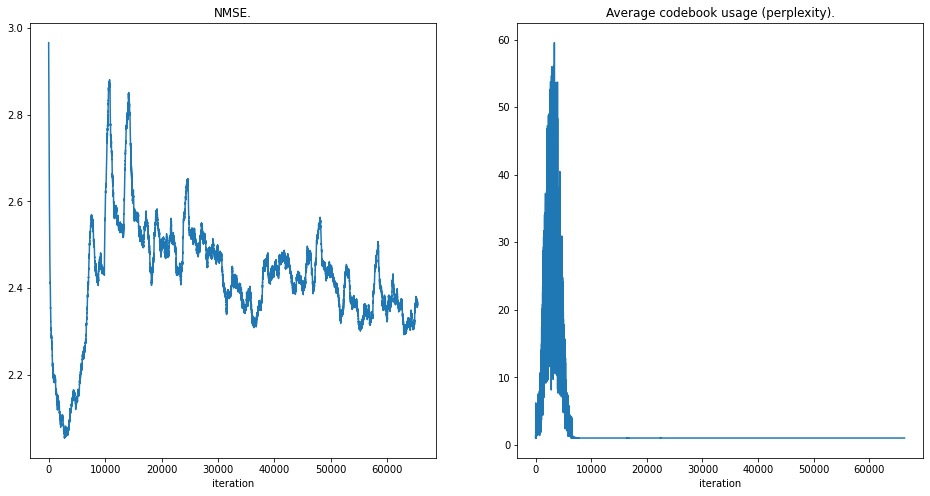

In [31]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(smooth_loss)
#ax.set_yscale('log')
ax.set_title('NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity)
ax.set_title('Average codebook usage (perplexity).')
ax.set_xlabel('iteration')
#I accidentally removed loss for first 20000 iterations or so.

[2.783576591983269, 2.2044351406508897, 2.4686223076040257, 2.178154204400058, 2.333901176258596, 2.1299057790470606, 2.283707162358299, 2.207365172163484, 2.263546703808633, 2.2469948029457614, 2.278596312638594, 2.6959738698102496, 2.308458966784847, 2.3646313212244645, 2.324766007092723, 2.410337677310566, 2.3748769415170514, 2.619241449282254, 2.3955095840829967, 2.521069503677678, 2.419069196975026, 2.8007799158544104, 2.4390619971724616, 2.5820194080396353, 2.4457193694317296, 2.602198345709573, 2.4521311290593433, 2.5074371899747607, 2.4562735538182023, 2.4970391702833514, 2.4589642825808036, 2.398451533716947, 2.460220610740321, 3.0417072240471237, 2.4609110118041615, 2.455890135565385, 2.4668098568221293, 2.6466588368875725, 2.4692997197459854, 2.5530113600534836, 2.471229296392451, 2.4438813360511955, 2.471757020682123, 2.4596470384125784, 2.4720052159366475, 2.445229036553862, 2.4708228277085085, 2.4880415045367883, 2.4675402092268888, 2.5032524434745613, 2.4655104144197515,

ValueError: x and y must have same first dimension, but have shapes (100,) and (0,)

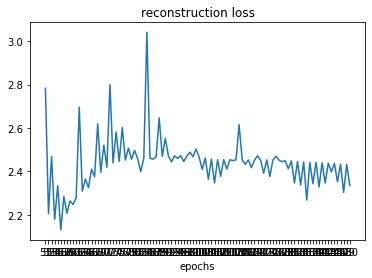

In [32]:
start = 51
print(training_reconstruction_errors_per_epochs)
end = len(training_reconstruction_errors_per_epochs)
x_axis = range(start, start + end)
plt.title("reconstruction loss")
plt.xlabel("epochs")
plt.xticks(np.arange(start, start + end, step=1))
plt.plot(x_axis, training_reconstruction_errors_per_epochs, label='train')
plt.plot(x_axis, validation_reconstruction_errors_per_epochs, label='test')
plt.legend()

In [ ]:
# x_axis = range(11, 31)
# plt.title("mcd")
# plt.xlabel("epochs")
# plt.xticks(np.arange(11, 31, step=1))
# plt.plot(x_axis, training_mcd_per_epochs, label='train')
# plt.plot(x_axis, validation_mcd_per_epochs, label='test')
# plt.legend()

## View Reconstructions

In [30]:
model.load_state_dict(torch.load("model_epoch"+str(300),map_location='cuda:0'))
optimizer.load_state_dict(torch.load("optim_epoch"+str(300), map_location='cuda:0'))

In [ ]:
# with open("errors", "wb") as file:
#     pickle.dump([train_res_recon_error, train_res_perplexity], file)

In [ ]:
#test encoding-decoding
# import librosa
# audio, sr = librosa.load("../VCTK/wav48/p225/p225_001.wav")
# normalized = librosa.util.normalize(audio) #divide max(abs(audio))
# mu_x = data.mu_law_encode(normalized, 256)
# bins = np.linspace(-1, 1, 256)
# quantized = np.digitize(mu_x, bins) - 1
# plt.plot(quantized[:100])
# plt.show()

# mu_rec = (quantized + 1) / 128 - 1
# plt.plot(mu_rec[:1000], color='red')
# plt.plot(mu_x[:1000], color='blue')
# plt.show()

# decoded = data.mu_law_decode(mu_rec, 256)
# plt.plot(normalized[:1000], color='blue')
# plt.plot(decoded[:1000], color='red')
# plt.show()

In [33]:
def mu_law_encode(data, mu):
    mu_x = np.sign(data) * np.log(1 + mu * np.abs(data)) / np.log(mu + 1)
    return mu_x

def mu_law_decode(mu_x, mu):
    data = np.sign(mu_x) * (1 / mu) * ((1 + mu) ** np.abs(mu_x) - 1)
    return data

def quantize_data(data, classes):
    mu_x = mu_law_encode(data, classes)
    bins = np.linspace(-1, 1, classes)
    quantized = np.digitize(mu_x, bins) - 1
    return quantized

In [34]:
import librosa

def generate(original_wav, speaker, filename = "generated.wav"):
    model.eval()
    with torch.no_grad():
        generated_file = np.array([])
        wav, sr = librosa.load(original_wav)
        print(len(wav))
        speaker_index = speaker_dic[speaker]
        
        normalized = librosa.util.normalize(wav)
        quantized = quantize_data(normalized, 256)
        
        
        
        for i in range(0, len(wav), 16126):
            sample = quantized[i:i+16126]
            
            
            if (len(sample)!= 16126):
                sample = np.append(sample, np.zeros(16126 - len(sample)).astype(int))
                print(16126 - len(sample))
                
            sample = torch.from_numpy(sample)
            print(sample)
            print(torch.max(sample), torch.min(sample))
            ohe_audio = torch.FloatTensor(256, 16126).zero_()
            ohe_audio.scatter_(0, sample.unsqueeze(0), 1.)
            
            speaker_id = torch.from_numpy(np.array(speaker_index)).unsqueeze(0).unsqueeze(0)
            ohe_speaker = torch.FloatTensor(number_of_speakers, 1).zero_()
            ohe_speaker.scatter_(0, speaker_id, 1.)

            ohe_audio = ohe_audio.unsqueeze(0).to(device)
            ohe_speaker = ohe_speaker.unsqueeze(0).to(device)
            encoded = model._encoder(ohe_audio)
            _, valid_quantize, _ = model._vq_vae(encoded)
            
            valid_reconstructions = model._decoder.incremental_forward(ohe_audio[:,:,0:1], 
                                                               valid_quantize, 
                                                               ohe_speaker, 
                                                               T=16126)
            
            
#         for i in range(0, len(wav), 16126):
#             sample = quantized[i:i+16126]
#             if (len(sample)!= 16126):
#                 sample = np.append(sample, np.zeros(16126 - len(sample)).astype(int))
                
#             sample = torch.from_numpy(sample)
#             print(sample)
#             print(torch.max(sample), torch.min(sample))
#             ohe_audio = torch.FloatTensor(256, 16126).zero_()
#             ohe_audio.scatter_(0, sample.unsqueeze(0), 1.)
            
#             speaker_id = torch.from_numpy(np.array(speaker_index)).unsqueeze(0).unsqueeze(0)
#             ohe_speaker = torch.FloatTensor(number_of_speakers, 1).zero_()
#             ohe_speaker.scatter_(0, speaker_id, 1.)

#             ohe_audio = ohe_audio.unsqueeze(0).to(device)
#             ohe_speaker = ohe_speaker.unsqueeze(0).to(device)
#             encoded = model._encoder(ohe_audio)
#             _, valid_quantize, _ = model._vq_vae(encoded)
            
#             valid_reconstructions = model._decoder.incremental_forward(ohe_audio[:,:,0:1], 
#                                                                valid_quantize, 
#                                                                ohe_speaker, 
#                                                                T=16126)
            
                
            recon = valid_reconstructions.squeeze().argmax(dim=0).detach().cpu().numpy()
            mu_encoded = (recon + 1) / 128 - 1
            mu_decoded = mu_law_decode(mu_encoded, mu=256)
            generated_file = np.append(generated_file, mu_decoded)
        print(len(generated_file))
        librosa.output.write_wav("generated.wav",  generated_file, sr=sr)
                

In [35]:
librosa.output
generate(original_wav = './VCTK/wav48/p225/p225_001.wav', speaker = 'p226', filename = "generated.wav")

45237
tensor([146, 154, 152,  ...,  96, 175, 129])
tensor(255) tensor(2)
tensor([ 73, 190, 147,  ..., 106, 142, 151])
tensor(250) tensor(8)
0
tensor([166, 176, 186,  ...,   0,   0,   0])
tensor(234) tensor(0)
48378


In [ ]:
model.eval()

original_wav = './VCTK/wav48/p225/p225_001.wav'
speaker_index = speaker_dic['p226']

wav, sr = librosa.load(original_wav)
print(len(wav))
speaker = np.eye(number_of_speakers)[speaker_index]
speaker = torch.tensor(speaker)
speaker = speaker.unsqueeze(0)

normalized = librosa.util.normalize(wav)
quantized = quantize_data(normalized, 256)

max_audio_start = quantized.shape[0] - 16126
if (max_audio_start > 0):
    audio_start = random.randint(0, max_audio_start)
    sample = quantized[audio_start:audio_start+16126]
else :
    sample = np.append(quantized, np.zeros(16126 - len(quantized))).astype(int)

sample = torch.from_numpy(sample)
ohe_audio = torch.FloatTensor(256, 16126).zero_()
ohe_audio.scatter_(0, sample.unsqueeze(0), 1.)

speaker_id = torch.from_numpy(np.array(speaker_index)).unsqueeze(0).unsqueeze(0)
ohe_speaker = torch.FloatTensor(number_of_speakers, 1).zero_()
ohe_speaker.scatter_(0, speaker_id, 1.)


valid_originals = ohe_audio.to(device).unsqueeze(0)
speaker_id = ohe_speaker.to(device).unsqueeze(0)

with torch.no_grad():
    encoded = model._encoder(valid_originals)

    _, valid_quantize, _ = model._vq_vae(encoded)
    #valid_reconstructions = model._decoder(valid_originals, valid_quantize, speaker_id) - this one works fine
    valid_reconstructions = model._decoder.incremental_forward(valid_originals[:,:,0:1], 
                                                               valid_quantize, 
                                                               speaker_id, 
                                                               T=16126)

In [ ]:
plt.plot(valid_quantize[:,0,:].detach().cpu().numpy().ravel())
plt.show()

In [ ]:
recon = valid_reconstructions.squeeze().argmax(dim=0).detach().cpu().numpy()
plt.plot(recon)
plt.show()

In [ ]:
orig = valid_originals.squeeze().argmax(dim=0).detach().cpu().numpy()
#plt.plot(valid_quantize.detach().numpy().ravel())
plt.plot(orig)
plt.show()

In [ ]:
recon = valid_reconstructions.squeeze().argmax(dim=0).detach().cpu().numpy()
mu_encoded = (recon + 1) / 128 - 1
mu_decoded = mu_law_decode(mu_encoded, mu=256)
plt.plot(mu_decoded[2000:4000])
plt.show()

In [ ]:
recon = valid_originals.squeeze().argmax(dim=0).detach().cpu().numpy()
mu_encoded_orig = (recon + 1) / 128 - 1
mu_decoded_orig = mu_law_decode(mu_encoded_orig, mu=256)
plt.plot(mu_decoded_orig[2000:4000])
plt.show()

In [ ]:
from IPython.display import Audio, display

In [ ]:
display(Audio(mu_decoded, rate=22050))

In [ ]:
display(Audio(mu_decoded_orig, rate=22050))

## View Embedding

In [31]:
embeddings = model._vq_vae._embedding.weight.data.cpu()
print(embeddings)
print(embeddings.shape)
# plt.plot(sorted(embeddings))
# plt.show()

tensor([[-1.2253e-04, -1.5952e-03, -7.7582e-04,  ...,  1.7549e-04,
          2.6436e-04,  9.4992e-05],
        [-5.1650e-04, -1.8270e-03,  1.8496e-03,  ..., -1.0357e-03,
         -1.4923e-03,  1.8243e-03],
        [-2.8573e-04, -1.4313e-03, -1.8282e-03,  ...,  1.5389e-03,
          3.7249e-04,  3.1927e-04],
        ...,
        [-7.8316e-01, -6.7304e-01, -5.9281e-01,  ...,  2.5027e-01,
          3.6906e-01,  5.6014e-01],
        [-7.9758e-04, -1.3218e-03, -1.6881e-03,  ..., -5.9832e-04,
          3.3609e-04, -1.1784e-03],
        [ 1.3237e-03, -9.0823e-04, -1.4231e-03,  ..., -2.6419e-04,
          9.5050e-04, -1.0242e-03]])
torch.Size([512, 64])


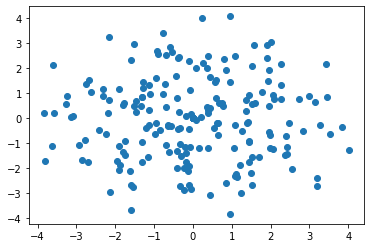

In [32]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
y = pca.fit_transform(embeddings)
plt.scatter(y[:,0],y[:,1])
plt.show()

In [35]:
print("done!")

done!
